# Wind turbine project

This notebook is a brief example of the possibilities offered by the toolbox for modeling extreme values, adapted from the tools provided from the ResourceCode website.

It relies on the `pyextreme` library which get installed with the Resourcecode toolbox. Here we demonstrate 2 examples of univariate modeling as shown in class. For more information, see https://georgebv.github.io/pyextremes/.

# I. Wave Dynamics

Part I of the wind turbine project spans 2 classes and consists of selecting a study site and analyzing the wave conditions at the study site. Last week you already began to select your study site, using criteria based on a wind speed threshold, water depth, and distance from the coast. Over the next 2 classes, you will: (A) characterize the mean wave conditions, and sea- sonal variability, and (B) estimate the extreme wave conditions. You will be asked to write up a concise report of your results of Parts I. A & B of the project (due on 24/10/2025). Some of this information will be needed in Parts II and III of your project to model wave transformation and to estimate the impacts of waves on an offshore wind turbine (OWT) for normal operating conditions and survival during extreme events. For the report concerning Part I of the project, please respond to the questions in I.A. (listed below) and I.B. (provided in next week’s class).

## I.A. Characterizing the study site mean wave conditions

The objective during this class is to characterize the mean wave conditions, as well as the seasonal and interannual variability. To do so, you can download wave time series from your study site from the ResourceCode wave database, which provides access to long-term (1994- 2020) hindcast simulations of wave conditions extending from 12°W to 13.5°E longitude, and from 36°N to 63°N latitude, covering the European and UK’s North Atlantic coast, Irish sea, the Northern Sea, and La Manche. This database was developed at the Ifremer by the LOPS (Laboratory of Ocean Physics and Satellite remote sensing), validated by the LOPS and LCSM (Marine Structures Laboratory), and analyzed at the LHEEA (Laboratory of Hydrody- namics, Energy and Atmospheric Environment) at Ecole Centrale Nantes.

The hindcast uses the WAVEWATCH III (WW3) version 7.08 (WW3DG, 2019) spectral wave model, implemented with unstructured grids that have higher resolution in the coastal zone, thus enabling the reproduction of the wave climate in relatively shallow water. It was forced by ERA5 wind felds with a resolution of 0.25°and by the surface currents generated from an atlas of harmonic tidal constituents obtained from outputs of the MARS 2D circulation model and the FES2014 model. The model is particularly well suited for predicting offshore wave conditions, as will be discussed further in class in the lecture presenting spectral wave models (S6). From the ResourceCode website, look at the ‘Explore’ tab to consult the map showing where wave time series are available (https://resourcecode.ifremer.fr/). Use the available toolbox to download the wave time series (available via the ‘Tools’ tab). Refer to the ResourceCode manual (available on the website and in the class repository) for more information about the available variables (about wind, waves, currents, bathymetry,...) and how they are calculated.

---

### Import Required Libraries




In [215]:
import os
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import pymannkendall as mk
from scipy import stats
from pathlib import Path
from pyextremes import (
    plot_mean_residual_life,
    plot_parameter_stability, 
    EVA
)
import resourcecode
from IPython import get_ipython

from resourcecode.eva import (
    get_fitted_models,
    get_gpd_parameters,
)
import warnings
warnings.filterwarnings("ignore")

os.makedirs('fig', exist_ok=True)
plt.savefig('fig/diagnostic_plot_bm.png', dpi=200, bbox_inches='tight')

# Enable inline plotting for Jupyter notebooks
get_ipython().run_line_magic("matplotlib", "inline")

---
### I.A.1. Mean Wave Conditions

Please download the variables corresponding to the significant wave height, mean wave period ($T_{m02}$), and mean wave direction. Then plot the time series of these variables during the 26-year period from 1994 to 2020, and calculate the mean significant wave height, period, and direction over the entire available time series.

### Chosen Study Site

**Site:** Bretagne Sud 1
**Coordinates:** $(47.3236111, -3.5522222)$. Coordinates were obtained by downloading the implantation zone KML files from https://www.eoliennesenmer.fr/facades-maritimes-en-france/facade-nord-atlantique-manche-ouest/projet-en-bretagne-sud/bretagne-sud-1. The KML files were then uploaded to Google Earth Pro, where a point at the centre of the zone was chosen, and those coordinates were used.

resourcecode.data.get_closest_point returns two things: the identifier of the grid node it matched (point_id) and the horizontal separation between your target coordinates and that node expressed in meters. So dist_m is that offset—how far (in meters) the chosen ResourceCode point lies from the latitude/longitude you supplied. If it’s near zero you’re right on top of a node; larger values mean the dataset had to pick the nearest available grid point.

Therefore, the point analysed is 1408.67 m away from the desired coordinates, which is insignificant and should not impact results much.


---
### Variables: definitions and units

**Core met-ocean time series**

| name   | meaning                                   | units |
|--------|-------------------------------------------|-------|
| `hs`   | significant wave height $H_{m0}=4\sqrt{m_0}$ | m     |
| `t02`  | mean zero-crossing period $T_{m02}=2\pi\sqrt{m_0/m_2}$ | s     |
| `dir`  | mean wave direction                       | °     |
| `spr`  | directional spreading                     | °     |
| `fp`   | spectral peak frequency                   | Hz    |
| `Tp`   | peak period $=1/fp$                     | s     |
| `uwnd` | eastward wind component                   | m·s⁻¹ |
| `vwnd` | northward wind component                  | m·s⁻¹ |
| `wspd` | wind speed $\sqrt{uwnd^2+vwnd^2}$       | m·s⁻¹ |
| `wdir` | wind direction                            | °     |
| `ucur` | eastward surface current                  | m·s⁻¹ |
| `vcur` | northward surface current                 | m·s⁻¹ |
| `cspd` | current speed $\sqrt{ucur^2+vcur^2}$    | m·s⁻¹ |
| `cdir` | current direction                         | °     |
| `dpt`  | water depth                               | m     |

**Spectral moments**

| name | meaning                               | units  |
|------|----------------------------------------|--------|
| `m0` | zeroth moment $\int S(\omega)\,d\omega$ | m²     |
| `m1` | first moment $\int \omega S(\omega)\,d\omega$ | m²·s⁻¹ |
| `m2` | second moment $\int \omega^2 S(\omega)\,d\omega$ | m²·s⁻² |

**Extreme value analysis (pyextremes)**

| item     | meaning                                  |
|----------|------------------------------------------|
| BM       | block-maxima extraction                  |
| POT      | peaks-over-threshold with declustering   |
| GEV $\mu,\sigma,\xi$ | location, scale, shape for BM     |
| GPD $\sigma,\xi$     | scale, shape for POT at a threshold |
| `r`      | min time separation between clusters     |
| `alpha`  | confidence level for intervals           |
| $z_T$  | return level for period $T$ years      |

**Direction conventions**

All directions are expressed **clockwise from North**.

| Variable | Convention | Notes |
|-----------|-------------|-------|
| `wdir` | *coming-from* | Derived from (`uwnd`, `vwnd`) using `resourcecode.utils.zmcomp2metconv`. |
| `dir_from` | *coming-from* | Use if dataset `dir` is *going-to*: convert by `dir_from = (dir + 180) % 360`. |
| `cdir_to` | *going-to* | Derived from (`ucur`, `vcur`); use as-is for current flow direction. |
| `cdir_from` | *coming-from* (optional) | For comparison with wave/wind directions, compute `cdir_from = (cdir_to + 180) % 360`. |

> Always state the convention in figure captions and keep it consistent across the notebook.

In [216]:
client = resourcecode.Client()
# load the resourcecode dataset from Bretagne Sud 1
# find the closest point to the coordinates
lat = 47.3236111
long = -3.5522222
point_id, dist_m = resourcecode.data.get_closest_point(latitude=lat, longitude=long)
print(point_id, dist_m)

# get the data from the closest point
data = client.get_dataframe_from_criteria(
    """
{
    "node": 117231,
    "start": 0,
    "end": 99999903600,
    "parameter": ["hs","t02","dir","uwnd","vwnd","ucur","vcur","dpt", "tp"]
}
"""
)

117231 1408.67


In [217]:
# Derive only what ResourceCode does not already provide
# Assumes your download included: hs, t02, dir, uwnd, vwnd (and optionally ucur, vcur, dpt)

# Wind: speed (m/s) and coming-from direction (deg)
data["wspd"], data["wdir"] = resourcecode.utils.zmcomp2metconv(data["uwnd"], data["vwnd"])

# Currents (optional)
if {"ucur", "vcur"}.issubset(data.columns):
    data["cspd"], data["cdir"] = resourcecode.utils.zmcomp2metconv(data["ucur"], data["vcur"])

# Waves: use provided mean zero-crossing period
if "t02" in data.columns:
    data["Tm02"] = data["t02"]
else:
    raise KeyError("Missing 't02' in the request. Add 't02' to parameter list.")

# Keep dataset wave direction as-is; document convention once in the notebook.
# Do NOT overwrite 'dir' or try to recompute Tm02 from hs/dir.

data = data.sort_index()
data.head()

,hs,t02,dir,uwnd,vwnd,ucur,vcur,dpt,tp,wspd,wdir,cspd,cdir,Tm02
1994-01-01 00:00:00,5.66,8.25,273.30,11.90,-6.40,-0.03,0.05,91.50,13.70,13.51,298.27,0.06,149.04,8.25
1994-01-01 01:00:00,5.73,8.36,272.90,11.60,-6.30,0.02,0.12,92.00,13.70,13.20,298.51,0.12,189.46,8.36
1994-01-01 02:00:00,5.70,8.44,272.40,11.10,-5.40,0.07,0.16,93.00,13.70,12.34,295.94,0.17,203.63,8.44
1994-01-01 03:00:00,5.61,8.47,272.10,11.00,-4.90,0.10,0.15,94.00,13.70,12.04,294.01,0.18,213.69,8.47
1994-01-01 04:00:00,5.48,8.43,272.10,10.90,-4.90,0.10,0.11,95.00,13.70,11.95,294.21,0.15,222.27,8.43


**Q: Do any trends in the wave height, period, or direction exist over the 26 year time period? Do you expect there to be changes in the mean conditions during the 30-year lifetime of the wind turbine? If so, why?**

<Figure size 640x480 with 0 Axes>

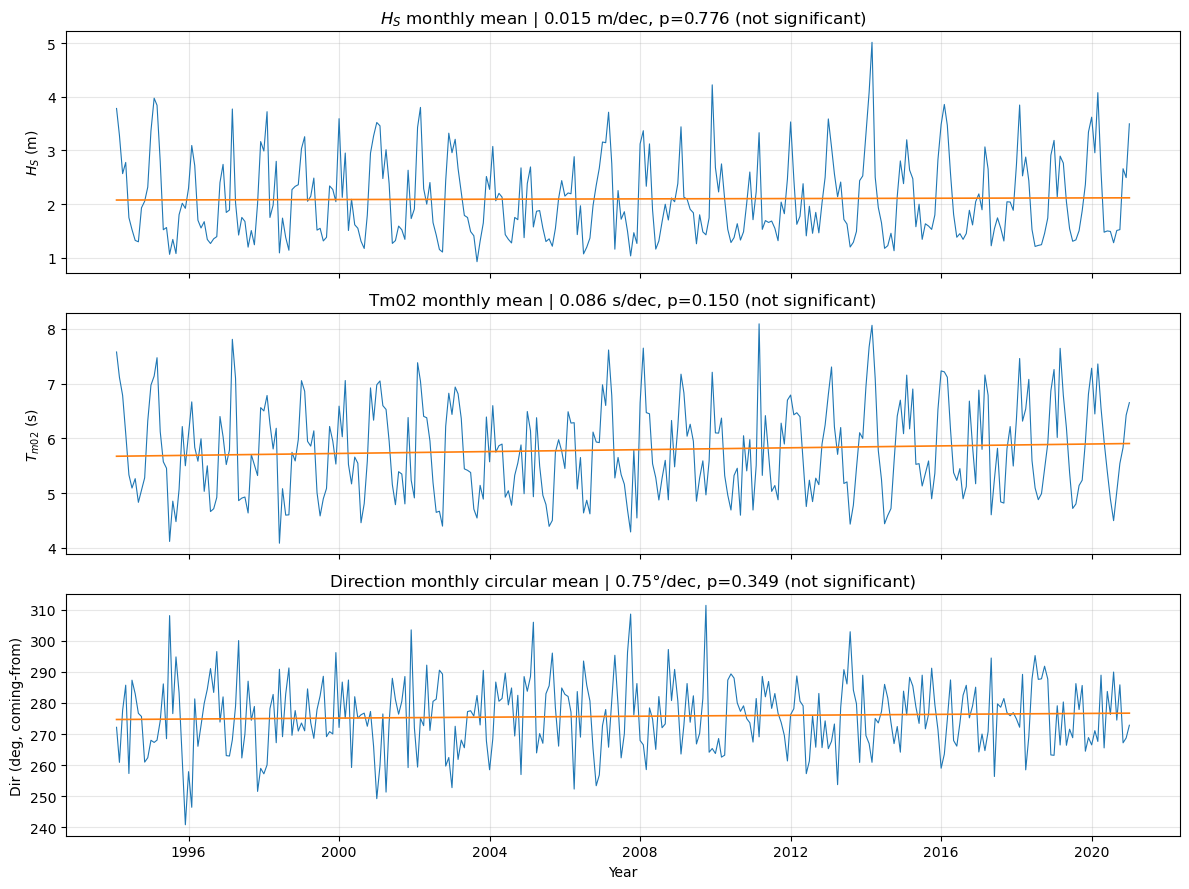

IA.1 — Mean conditions over 1994–2020
  Mean Hs   : 2.092 m
  Mean Tm02 : 5.785 s
  Mean Dir  : 275.5° (coming-from)

Linear trends on monthly means (least squares):
  Hs   : 0.015 m/dec  (p=0.776, n=324), Δ30y=0.046 m
  Tm02 : 0.086 s/dec  (p=0.150, n=324), Δ30y=0.259 s
  Dir  : 0.75 °/dec (p=0.349, n=324), Δ30y=2.26 °

Interpretation rule-of-thumb: treat p<0.05 as evidence of a trend. Use Δ30y to state expected change over a turbine lifetime.


In [218]:
# IA.1 — Mean wave conditions (1994–2020): time series, means, linear trends

def circmean_deg(x_deg):
    """Circular mean of degrees in [0, 360)."""
    x = pd.Series(x_deg).dropna().values
    if x.size == 0:
        return np.nan
    r = np.deg2rad(x)
    s = np.sin(r).sum()
    c = np.cos(r).sum()
    return (np.degrees(np.arctan2(s, c)) + 360.0) % 360.0

def verdict(p):
    return "significant" if p < 0.05 else "not significant"

# helper
def wrap360(a):
    return (a % 360.0 + 360.0) % 360.0

# Select analysis window
start = pd.Timestamp("1994-01-01")
end   = pd.Timestamp("2020-12-31 23:59:59")
needed = ["hs", "Tm02", "dir"]
missing = [v for v in needed if v not in data.columns]
if missing:
    raise KeyError(f"Missing variables for IA.1: {missing}")

df = data.loc[start:end, needed].copy()

# Monthly means (direction handled circularly)
monthly = pd.DataFrame({
    "hs":   df["hs"].resample("M").mean(),
    "Tm02": df["Tm02"].resample("M").mean(),
})
monthly["dir"] = df["dir"].resample("M").apply(circmean_deg)

# Overall means (direction: circular mean)
mean_hs   = df["hs"].mean()
mean_tm02 = df["Tm02"].mean()
mean_dir  = circmean_deg(df["dir"])

# Linear trends on monthly means
t_years = (monthly.index - monthly.index[0]).days / 365.2425

# Hs trend
hs_ok = monthly["hs"].dropna()
t_hs = t_years[hs_ok.index.get_indexer(hs_ok.index)]
hs_reg = stats.linregress(t_hs, hs_ok.values)
hs_slope_dec = hs_reg.slope * 10.0      # m per decade
hs_delta_30  = hs_reg.slope * 30.0      # m over 30 years

# Tm02 trend
tm_ok = monthly["Tm02"].dropna()
t_tm = t_years[tm_ok.index.get_indexer(tm_ok.index)]
tm_reg = stats.linregress(t_tm, tm_ok.values)
tm_slope_dec = tm_reg.slope * 10.0      # s per decade
tm_delta_30  = tm_reg.slope * 30.0      # s over 30 years

# Direction trend: unwrap, regress, report slope in deg/dec
dir_ok = monthly["dir"].dropna()
t_dir = t_years[dir_ok.index.get_indexer(dir_ok.index)]
dir_unwrap = np.degrees(np.unwrap(np.deg2rad(dir_ok.values)))
dir_reg = stats.linregress(t_dir, dir_unwrap)
dir_slope_dec = dir_reg.slope * 10.0    # deg per decade
dir_delta_30  = dir_reg.slope * 30.0    # deg over 30 years

# Plot monthly series (1994–2020)
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Hs with fitted line
axes[0].plot(monthly.index, monthly["hs"], lw=0.8)
yhat_hs = hs_reg.intercept + hs_reg.slope * t_years
axes[0].plot(monthly.index, yhat_hs, lw=1.2)
axes[0].set_ylabel("$H_S$ (m)")
axes[0].grid(alpha=0.3)
axes[0].set_title(f"$H_S$ monthly mean | {hs_slope_dec:.3f} m/dec, p={hs_reg.pvalue:.3f} ({verdict(hs_reg.pvalue)})")

# Tm02 with fitted line
axes[1].plot(monthly.index, monthly["Tm02"], lw=0.8)
yhat_tm = tm_reg.intercept + tm_reg.slope * t_years
axes[1].plot(monthly.index, yhat_tm, lw=1.2)
axes[1].set_ylabel("$T_{m02}$ (s)")
axes[1].grid(alpha=0.3)
axes[1].set_title(f"Tm02 monthly mean | {tm_slope_dec:.3f} s/dec, p={tm_reg.pvalue:.3f} ({verdict(tm_reg.pvalue)})")

# Direction (circular monthly mean) with fitted line
axes[2].plot(monthly.index, monthly["dir"], lw=0.8)
yhat_dir_unwrap = dir_reg.intercept + dir_reg.slope * t_years
yhat_dir = wrap360(yhat_dir_unwrap)
axes[2].plot(monthly.index, yhat_dir, lw=1.2)  # add fit
axes[2].set_ylabel("Dir (deg, coming-from)")
axes[2].grid(alpha=0.3)
axes[2].set_title(
    f"Direction monthly circular mean | {dir_slope_dec:.2f}°/dec, "
    f"p={dir_reg.pvalue:.3f} ({verdict(dir_reg.pvalue)})"
)
axes[2].set_xlabel("Year")

plt.tight_layout()
plt.savefig("fig/IA1_mean_wave_conditions_timeseries.png", dpi=200, bbox_inches="tight")
plt.show()

# Printed summary for the report
print("IA.1 — Mean conditions over 1994–2020")
print(f"  Mean Hs   : {mean_hs:.3f} m")
print(f"  Mean Tm02 : {mean_tm02:.3f} s")
print(f"  Mean Dir  : {mean_dir:.1f}° (coming-from)")

print("\nLinear trends on monthly means (least squares):")
print(f"  Hs   : {hs_slope_dec:.3f} m/dec  (p={hs_reg.pvalue:.3f}, n={hs_ok.size}), Δ30y={hs_delta_30:.3f} m")
print(f"  Tm02 : {tm_slope_dec:.3f} s/dec  (p={tm_reg.pvalue:.3f}, n={tm_ok.size}), Δ30y={tm_delta_30:.3f} s")
print(f"  Dir  : {dir_slope_dec:.2f} °/dec (p={dir_reg.pvalue:.3f}, n={dir_ok.size}), Δ30y={dir_delta_30:.2f} °")

print("\nInterpretation rule-of-thumb: treat p<0.05 as evidence of a trend. Use Δ30y to state expected change over a turbine lifetime.")

In [219]:
result_hs  = mk.original_test(hs_ok.values, alpha=0.05)
result_period = mk.original_test(tm_ok.values, alpha=0.050)
result_direction = mk.original_test(dir_ok.values, alpha=0.05)

print("\nResults for Significant Wave Height (Hs):")
print(f"  Trend: {result_hs.trend}")
print(f"  H (Test Statistic): {result_hs.h}")
print(f"  P-value: {result_hs.p:.4f}")
print(f"  Z-Score: {result_hs.z:.4f}")
print(f"  Tau: {result_hs.Tau:.4f}")
print(f"  Sen's Slope: {result_hs.slope:.4f}")
print(f"  Intercept: {result_hs.intercept:.4f}")

print("\nResults for Wave Period (Tm02):")
print(f"  Trend: {result_period.trend}")
print(f"  H (Test Statistic): {result_period.h}")
print(f"  P-value: {result_period.p:.4f}")
print(f"  Z-Score: {result_period.z:.4f}")
print(f"  Tau: {result_period.Tau:.4f}")
print(f"  Sen's Slope: {result_period.slope:.4f}")
print(f"  Intercept: {result_period.intercept:.4f}")

print("\nResults for Wave Direction:")
print(f"  Trend: {result_direction.trend}")
print(f"  H (Test Statistic): {result_direction.h}")
print(f"  P-value: {result_direction.p:.4f}")
print(f"  Z-Score: {result_direction.z:.4f}")
print(f"  Tau: {result_direction.Tau:.4f}")
print(f"  Sen's Slope: {result_direction.slope:.4f}")
print(f"  Intercept: {result_direction.intercept:.4f}")


Results for Significant Wave Height (Hs):
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.8098
  Z-Score: 0.2407
  Tau: 0.0090
  Sen's Slope: 0.0001
  Intercept: 1.8970

Results for Wave Period (Tm02):
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.1957
  Z-Score: 1.2938
  Tau: 0.0482
  Sen's Slope: 0.0007
  Intercept: 5.5974

Results for Wave Direction:
  Trend: no trend
  H (Test Statistic): False
  P-value: 0.4405
  Z-Score: 0.7714
  Tau: 0.0287
  Sen's Slope: 0.0055
  Intercept: 275.0205


**Answer:** No statistically significant trends were detected in wave height ($H_s$), period ($T_{m02}$), or direction using either Ordinary Least Squares (OLS) or the Mann-Kendall (MK) test on monthly mean data. Expected 30-year changes in mean conditions remain negligible relative to natural variability.

---
### Mean Conditions and Trend Analysis (1994-2020)

**Mean conditions**
-   $\overline{H_s} = 2.092\ \text{m}$
-   $\overline{T_{m02}} = 5.785\ \text{s}$
-   Mean direction $= 275.5^\circ$ (coming from W)

---
**Trend Analysis Methods**
-   Aggregate hourly data to monthly means to reduce noise while retaining seasonal information influence.
-   **Method 1: Ordinary Least Squares (OLS)**: Perform regression vs time in years. Direction handled with circular monthly mean, then unwrapped.
-   **Method 2: Mann-Kendall (MK) Test**: Apply the non-parametric test to detect monotonic trends in the monthly mean time series.
-   Significance for both methods assessed at $\alpha=0.05$.

---
**OLS Results** (slope per decade; $\Delta 30\text{y}$ is implied 30-year change; $n=324$ monthly means)
-   $H_s$: $+0.015\ \text{m/dec}$, $p=0.776$, $\Delta 30\text{y}\approx +0.046\ \text{m}$. (No significant trend)
-   $T_{m02}$: $+0.086\ \text{s/dec}$, $p=0.150$, $\Delta 30\text{y}\approx +0.259\ \text{s}$. (No significant trend)
-   Direction: $+0.75^\circ/\text{dec}$, $p=0.349$, $\Delta 30\text{y}\approx +2.26^\circ$. (No significant trend)

---
**MK Results (on monthly means)**
-   $H_s$: $p=0.8098$ (no significant trend); Sen's slope $\approx +1.0\times10^{-4}$ m/month ($\approx +0.012$ m/decade).
-   $T_{m02}$: $p=0.1957$ (no significant trend); Sen's slope $\approx +7.0\times10^{-4}$ s/month ($\approx +0.084$ s/decade).
-   Direction: $p=0.4405$ (no significant trend); Sen's slope $\approx +5.5\times10^{-3}$ deg/month ($\approx +0.66^\circ$/decade).

*(Note: Sen's slopes converted approximately from per-month to per-decade for comparison with OLS results)*

---
**Interpretation**
-   Both OLS and Mann-Kendall analyses performed on monthly mean data consistently indicate no statistically significant secular trends in mean $H_s$, $T_{m02}$, or direction over the 1994-2020 period.
-   The magnitudes of the calculated slopes (both OLS and Sen's slope) are very small, suggesting that any potential underlying linear or monotonic change over the 26 years is minimal compared to the observed variability.
-   Expected 30-year changes based on these negligible trends are small compared to the substantial seasonal and interannual variability present in the data.
-   For design purposes over the next 30 years, emphasis should likely remain on characterizing the existing variability (seasonal, interannual) and extreme conditions rather than adjusting significantly for potential drifts in mean conditions.



---
### I.A.2. Most Common Wave Conditions

To identify the most common operating conditions, we will create a 2D histogram (scatter diagram) of significant wave height ($H_{m0}$) versus mean wave period ($T_{m02}$). We will also plot a wave rose to identify the most common wave incidence direction(s).









Water depth: mean h = 93.32 m (std = 1.18 m) at (47.3236111, -3.5522222)
Deep-water threshold: T < 12.34 s
Shallow-water (linear) threshold: T > 77.11 s


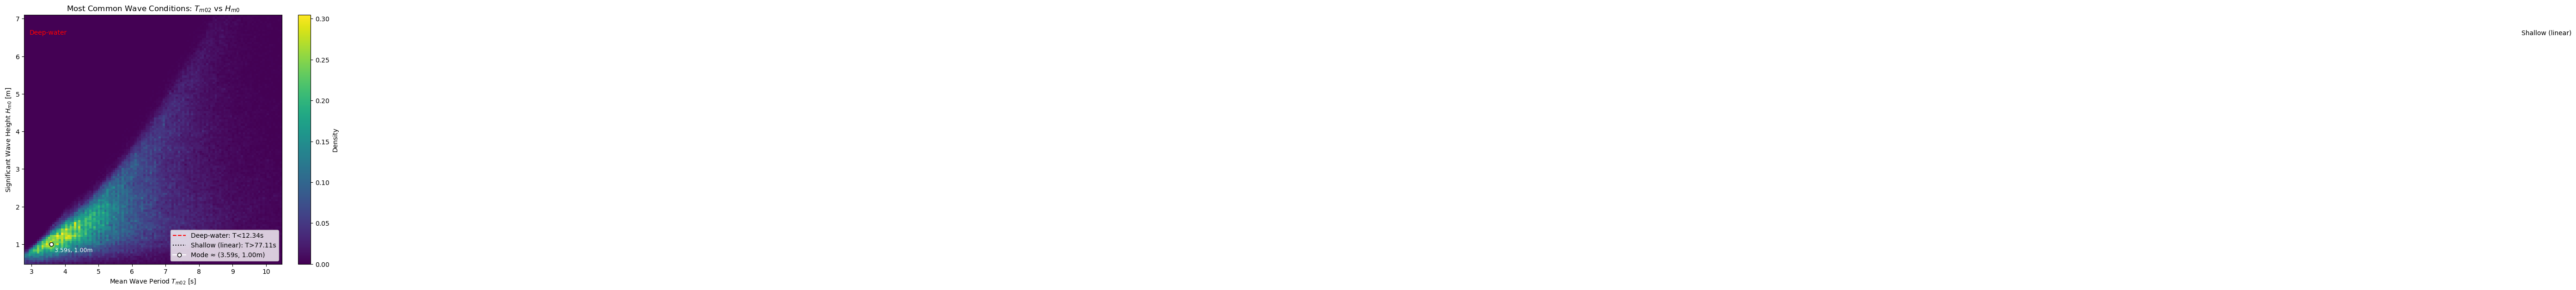

Share deep-water (T<12.34s): 99.98%
Share shallow (linear) (T>77.11s): 0.0000%
Share transition: 0.02%


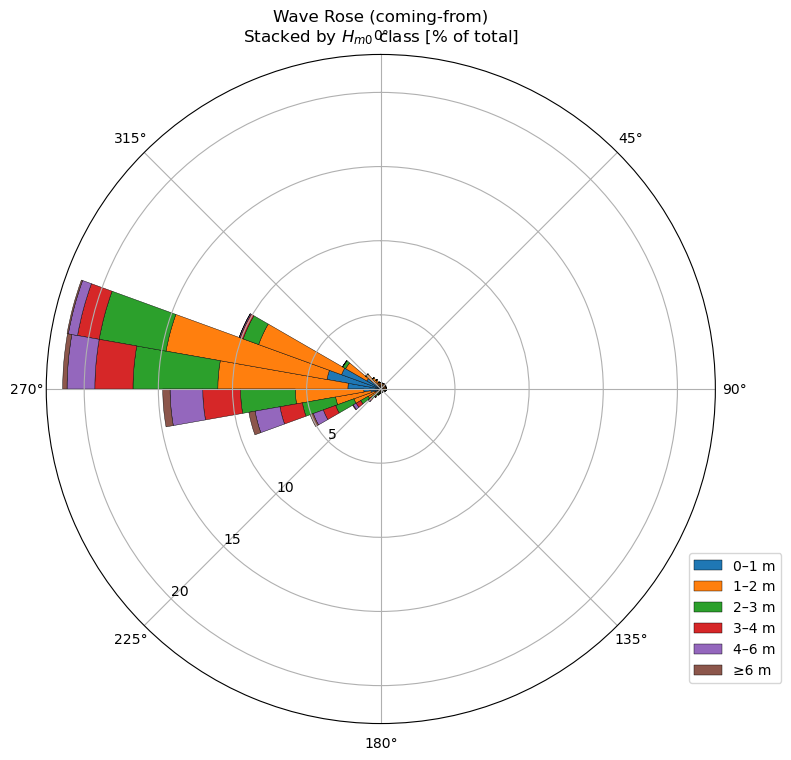

Most common incidence direction bin center: 285.0° (coming-from)


In [220]:
# I.A.2 — Most common wave conditions: (T_m02, H_m0) scatter diagram + deep/linear regimes + wave rose
# --------------------------
# Inputs and thresholds
# --------------------------
g = 9.81  # m/s^2
lat = float(lat) if "lat" in globals() else np.nan
long = float(long) if "long" in globals() else np.nan

# Clean series
T = pd.to_numeric(data["t02"], errors="coerce").to_numpy()
Hs = pd.to_numeric(data["hs"],  errors="coerce").to_numpy()
Dpt = pd.to_numeric(data["dpt"], errors="coerce").to_numpy()
Dir = pd.to_numeric(data["dir"], errors="coerce").to_numpy() if "dir" in data.columns else None

mask = np.isfinite(T) & np.isfinite(Hs) & np.isfinite(Dpt)
if Dir is not None:
    mask = mask & np.isfinite(Dir)

T = T[mask]
Hs = Hs[mask]
Dpt = Dpt[mask]
Dir = Dir[mask] if Dir is not None else None

h_mean = float(np.nanmean(Dpt))
h_std  = float(np.nanstd(Dpt))

# Deep and shallow (linear shallow-water) period thresholds at mean depth
T_deep    = 4.0 * np.sqrt(h_mean / g)     # deep-water if T < T_deep
T_shallow = 25.0 * np.sqrt(h_mean / g)    # shallow-water (linear nondispersive) if T > T_shallow

print(f"Water depth: mean h = {h_mean:.2f} m (std = {h_std:.2f} m) at ({lat}, {long})")
print(f"Deep-water threshold: T < {T_deep:.2f} s")
print(f"Shallow-water (linear) threshold: T > {T_shallow:.2f} s")

# --------------------------
# 2D histogram: period on x, Hs on y
# --------------------------
# Bin ranges, robust to outliers
T_max_plot = np.nanpercentile(T, 99.5)
Hs_max_plot = np.nanpercentile(Hs, 99.5)
T_min_plot = max(0.0, np.nanpercentile(T, 0.5))
Hs_min_plot = max(0.0, np.nanpercentile(Hs, 0.5))

xbins = np.linspace(T_min_plot, T_max_plot, 120)
ybins = np.linspace(Hs_min_plot, Hs_max_plot, 120)

H2, xedges, yedges = np.histogram2d(T, Hs, bins=[xbins, ybins], density=True)
# Peak (most common) conditions from density maximum
imax = np.unravel_index(np.nanargmax(H2), H2.shape)
T_mode = 0.5 * (xedges[imax[0]] + xedges[imax[0] + 1])
Hs_mode = 0.5 * (yedges[imax[1]] + yedges[imax[1] + 1])

# Plot
plt.figure(figsize=(9, 7))
plt.hist2d(T, Hs, bins=[xbins, ybins], density=True, cmap="viridis")
cbar = plt.colorbar()
cbar.set_label("Density")

# Thresholds: vertical lines in T
plt.axvline(T_deep, color="red", linestyle="--", linewidth=1.5, label=f"Deep-water: T<{T_deep:.2f}s")
plt.axvline(T_shallow, color="black", linestyle=":", linewidth=1.5, label=f"Shallow (linear): T>{T_shallow:.2f}s")

# Annotate regions
y_txt = Hs_min_plot + 0.92 * (Hs_max_plot - Hs_min_plot)
plt.text(T_min_plot + 0.02*(T_max_plot-T_min_plot), y_txt, "Deep-water", color="red", fontsize=10)
plt.text(T_shallow + 0.02*(T_max_plot-T_min_plot), y_txt, "Shallow (linear)", color="black", fontsize=10)

# Most common bin marker
plt.plot(T_mode, Hs_mode, marker="o", markersize=6, color="white", mec="k", label=f"Mode ≈ ({T_mode:.2f}s, {Hs_mode:.2f}m)")
plt.annotate(f"{T_mode:.2f}s, {Hs_mode:.2f}m", xy=(T_mode, Hs_mode),
             xytext=(5, -12), textcoords="offset points", color="white", fontsize=9)

plt.xlabel("Mean Wave Period $T_{m02}$ [s]")
plt.ylabel("Significant Wave Height $H_{m0}$ [m]")
plt.title("Most Common Wave Conditions: $T_{m02}$ vs $H_{m0}$")
plt.legend(loc="lower right", frameon=True)
Path("graphs").mkdir(parents=True, exist_ok=True)
plt.tight_layout()
plt.savefig("graphs/wave_T_vs_Hs_density.png", dpi=200)
plt.show()
plt.close()

# Quantify shares for reference
pct_deep = np.mean(T < T_deep) * 100.0
pct_shallow = np.mean(T > T_shallow) * 100.0
pct_transition = 100.0 - pct_deep - pct_shallow
print(f"Share deep-water (T<{T_deep:.2f}s): {pct_deep:.2f}%")
print(f"Share shallow (linear) (T>{T_shallow:.2f}s): {pct_shallow:.4f}%")
print(f"Share transition: {pct_transition:.2f}%")

# --------------------------
# Wave rose: most common wave incidence directions
# --------------------------
if Dir is not None:
    # Define Hs classes for a classic wave rose (adjust as needed)
    hs_bins = [0, 1, 2, 3, 4, 6, np.inf]
    hs_labels = ["0–1", "1–2", "2–3", "3–4", "4–6", "≥6"]  # m

    # Direction bins (every 10°)
    n_dir_bins = 36
    dir_edges_deg = np.linspace(0, 360, n_dir_bins + 1)
    dir_centers_deg = 0.5 * (dir_edges_deg[:-1] + dir_edges_deg[1:])
    dir_edges_rad = np.deg2rad(dir_edges_deg)

    # Prepare stacked counts per Hs class
    counts_stack = []
    for i in range(len(hs_bins) - 1):
        mask_h = (Hs >= hs_bins[i]) & (Hs < hs_bins[i + 1])
        hist, _ = np.histogram(Dir[mask_h] % 360.0, bins=dir_edges_deg)
        counts_stack.append(hist.astype(float))
    counts_stack = np.array(counts_stack)  # shape: [n_hs_classes, n_dir_bins]

    # Convert counts to percentages
    total_counts = counts_stack.sum(axis=0)
    total_all = total_counts.sum()
    frac_stack = (counts_stack / total_all) * 100.0  # percent of total occurrences

    # Polar plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="polar")
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    bottom = np.zeros(n_dir_bins)
    width = np.diff(dir_edges_rad)

    for i, label in enumerate(hs_labels):
        ax.bar(np.deg2rad(dir_centers_deg), frac_stack[i], width=width,
               bottom=bottom, align="center", edgecolor="k", linewidth=0.3, label=f"{label} m")
        bottom += frac_stack[i]

    ax.set_title("Wave Rose (coming-from)\nStacked by $H_{m0}$ class [% of total]", va="bottom")
    ax.set_rlabel_position(225)
    ax.legend(loc="lower left", bbox_to_anchor=(0.95, 0.05), frameon=True)
    plt.tight_layout()
    plt.savefig("graphs/wave_rose_stacked_Hs.png", dpi=200)
    plt.show()
    plt.close()

    # Also print the dominant direction sector by total frequency
    dom_bin = int(np.argmax(total_counts))
    dom_dir_center = dir_centers_deg[dom_bin]
    print(f"Most common incidence direction bin center: {dom_dir_center:.1f}° (coming-from)")
else:
    print("Column 'dir' not found. Skipping wave rose.")


**Q: What is the water depth at this location? Indicate on the histrogram for what wave conditions the waves are considered deep water waves? linear waves?**

1.17577492579537
mean water depth at location (lat, long) = (47.3236111, -3.5522222) is 93.32 m
percentage of deep water waves: 99.76%
deep water period: 12.34 s


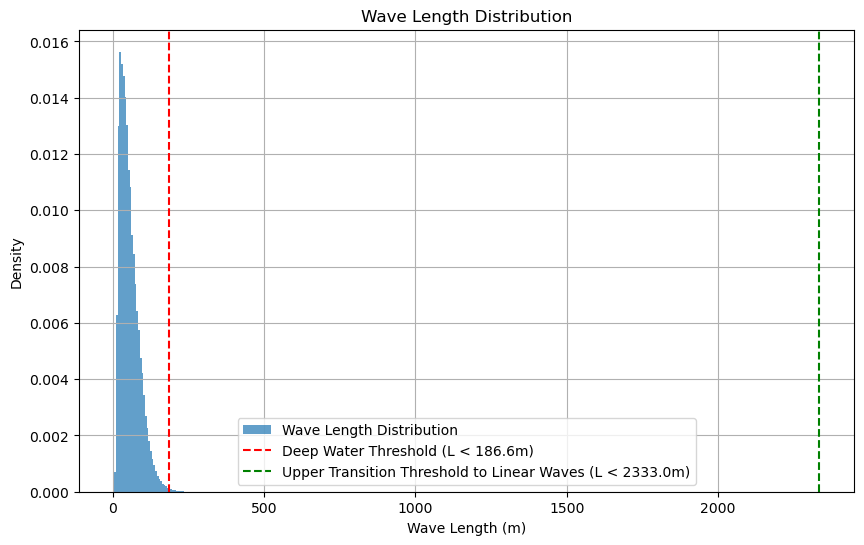

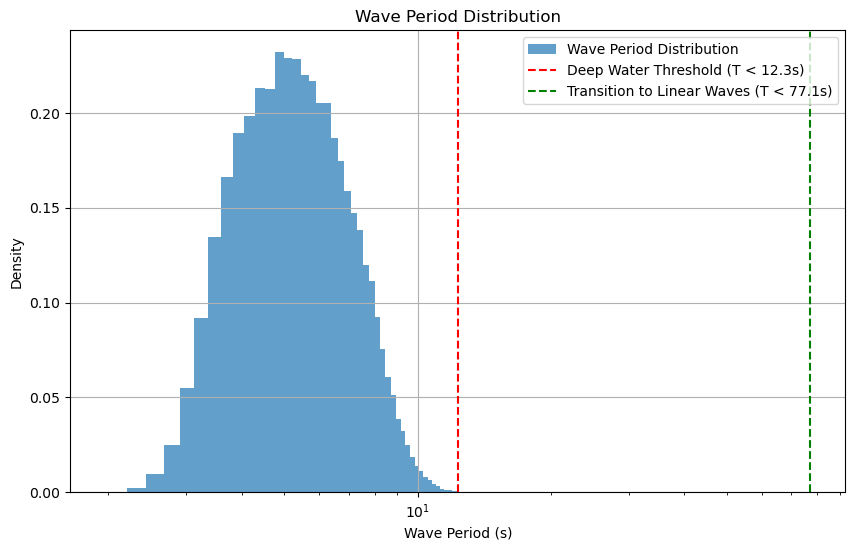


--- Result Summary ---
Analysis based on Mean Depth h = 93.32 m

Thresholds:
  Deep Water:     L < 186.6 m   |   T < 12.34 s
  Intersection of Deep and Shallow Water:  L > 2333.0 m  |   T > 77.11 s

Classification based on Approximate Wavelength (L_approx = gT² / 2π):
  Percentage Deep Water Wave Lenghts: 99.76%
  Percentage Transition Zone Wave Lenghts: 0.24%

Classification based on Approximate Wavelength (L_approx = gT² / 2π):
  Percentage Deep Water Wave Periods: 99.98%
  Percentage Transition Zone Wave Periods: 0.02%


In [221]:
print(data['dpt'].std())

mean_water_depth = data['dpt'].mean()
print(f'mean water depth at location (lat, long) = ({lat}, {long}) is {mean_water_depth:.2f} m')

# Calculating wave length using the linear wave theory
# wave length = g * T^2 / (2 * pi)
g = 9.81 # m/s^2
wave_length = g * (data['t02']**2) / (2 * np.pi)
water_depth = data['dpt']

# check condition for deep water waves
deep_water_length_condition = 2 * mean_water_depth
transition_water_length_condition = 25 * mean_water_depth

deep_water_condition = wave_length < deep_water_length_condition
# calculate the percentage of deep water waves
deep_water_percentage = deep_water_condition.mean()
print(f'percentage of deep water waves: {deep_water_percentage:.2%}')

# Compute corresponding period for deep water waves
deep_water_period_condition = 4 * np.sqrt(mean_water_depth / g)
transition_water_period_condition = 25 * np.sqrt(mean_water_depth / g)

print(f'deep water period: {deep_water_period_condition:.2f} s')
# check condition for linear waves
#linear_waves_condition = wave_length > 20 * mean_water_depth

### plot the wave length distribution ###
plt.figure(figsize=(10, 6))

# Corrected plt.hist call: remove wave_length.count
plt.hist(wave_length, bins=50, density=True, alpha=0.7, label='Wave Length Distribution')

# Add the threshold line (assuming L < 2h for deep water)
plt.axvline(x=deep_water_length_condition, color='r', linestyle='--',
            label=f'Deep Water Threshold (L < {deep_water_length_condition:.1f}m)')
plt.axvline(x=transition_water_length_condition, color='g', linestyle='--',
            label=f'Upper Transition Threshold to Linear Waves (L < {transition_water_length_condition:.1f}m)')
plt.xlabel('Wave Length (m)')
plt.ylabel('Density') # Changed label to Density since density=True
plt.title('Wave Length Distribution')
plt.legend()
plt.grid(True)
plt.show()
plt.close() # Close after showing

plt.figure(figsize=(10, 6))
### plot the wave period distribution ###
plt.hist(data['t02'], bins=50, density=True, alpha=0.7, label='Wave Period Distribution')

# Add the threshold line (assuming L < 2h for deep water)
plt.axvline(x=deep_water_period_condition, color='r', linestyle='--',
            label=f'Deep Water Threshold (T < {deep_water_period_condition:.1f}s)')
plt.axvline(x=transition_water_period_condition, color='g', linestyle='--',
            label=f'Transition to Linear Waves (T < {transition_water_period_condition:.1f}s)')
plt.xlabel('Wave Period (s)')
plt.xscale('log')
plt.ylabel('Density') # Changed label to Density since density=True
plt.title('Wave Period Distribution')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# --- 6. Result Summary ---
print("\n--- Result Summary ---")
print(f"Analysis based on Mean Depth h = {mean_water_depth:.2f} m")

print("\nThresholds:")
print(f"  Deep Water:     L < {deep_water_length_condition:.1f} m   |   T < {deep_water_period_condition:.2f} s")
print(f"  Intersection of Deep and Shallow Water:  L > {transition_water_length_condition:.1f} m  |   T > {transition_water_period_condition:.2f} s")

# Compute the percentage of deep water waves based on the approximate wavelength
is_deep_water_wave = wave_length < deep_water_length_condition
is_transition_zone_wave = (
    (deep_water_length_condition < wave_length) &
    (wave_length < transition_water_length_condition)
)

is_deep_water_period = data['t02'] < deep_water_period_condition
is_transition_zone_period = (
    (deep_water_period_condition < data['t02']) &
    (data['t02'] < transition_water_period_condition)
)
# get a percentage of the boolean series of true and false
deep_water_percentage_L_approx = is_deep_water_wave.mean()
transition_percentage_L_approx = is_transition_zone_wave.mean()
deep_water_percentage_T_approx = is_deep_water_period.mean()
transition_percentage_T_approx = is_transition_zone_period.mean()

print("\nClassification based on Approximate Wavelength (L_approx = gT² / 2π):")
print(f"  Percentage Deep Water Wave Lenghts: {deep_water_percentage_L_approx:.2%}")
print(f"  Percentage Transition Zone Wave Lenghts: {transition_percentage_L_approx:.2%}")

# Characterizing the transition band for T
print("\nClassification based on Approximate Wavelength (L_approx = gT² / 2π):")
print(f"  Percentage Deep Water Wave Periods: {deep_water_percentage_T_approx:.2%}")
print(f"  Percentage Transition Zone Wave Periods: {transition_percentage_T_approx:.2%}")

### Wave Regime Classification

**Method**

- Hourly conditions classified into deep, transitional, and shallow regimes using $H_s$, $T_{m02}$, depth $h$, wavelength $L$.
- Fixed mean depth $h=93.32\ \text{m}$ (depth variability small: $\sigma_h=1.2\ \text{m}$).
- Two diagnostics:
  1) Period criterion via $T\sqrt{g/h}$.
  2) Approximate deep-water wavelength $L_{\text{approx}}=\dfrac{g\,T_{m02}^2}{2\pi}$ for a fast screen.
- $g=9.81\ \text{m s}^{-2}$.

---

**Thresholds** (at $h=93.32\ \text{m}$)

- **Deep water**: $h/L>1/2\ \Rightarrow\ L<186.6\ \text{m}$; equivalently $T\sqrt{g/h}<4\ \Rightarrow\ T<12.34\ \text{s}$.
- **Shallow water**: $h/L<1/25\ \Rightarrow\ L>2333.0\ \text{m}$; equivalently $T\sqrt{g/h}>25\ \Rightarrow\ T>77.11\ \text{s}$.
- **Transition zone**: between these limits.

---

**Results**

- **Classification by approximate wavelength** $(L_{\text{approx}})$:
  - Deep water ($L_{\text{approx}}<186.6\ \text{m}$): **99.76%**
  - Transition zone ($186.6\le L_{\text{approx}}\le 2333.0\ \text{m}$): **0.24%**
  - Shallow water ($L_{\text{approx}}>2333.0\ \text{m}$): **0.00%**

- **Classification by period** $(T_{m02})$:
  - Deep water ($T<12.34\ \text{s}$): **99.98%**
  - Transition zone ($12.34\le T\le 77.11\ \text{s}$): **0.02%**
  - Shallow water ($T>77.11\ \text{s}$): **0.00%**

---

**Interpretation**

- The site operates **almost entirely in deep water**. Period- and wavelength-based diagnostics both yield >99.7% deep conditions; the period test is slightly more conservative here.
- **Transition cases are rare** (0.02–0.24%) and occur near the deep/transition boundary; none reach shallow-water criteria.
- Using $L_{\text{approx}}$ is adequate for screening at this depth because periods rarely approach the transitional threshold. For edge cases, the direct period criterion $T\sqrt{g/h}$ remains the most transparent.


---
### I.A.3. Seasonal Variability

Next, we will evaluate temporal variability by calculating and plotting the mean wave height, period, and direction as a function of the month of the year (e.g., mean for January, February, etc.).

**Data and method.** Hourly hindcast at coordinates. Monthly climatology across all years.  
- Height and period: arithmetic mean with interquartile range (IQR).  
- Direction: circular mean with circular standard deviation, expressed as *coming-from* degrees.  
- Angles unwrapped around the overall mean for continuity.

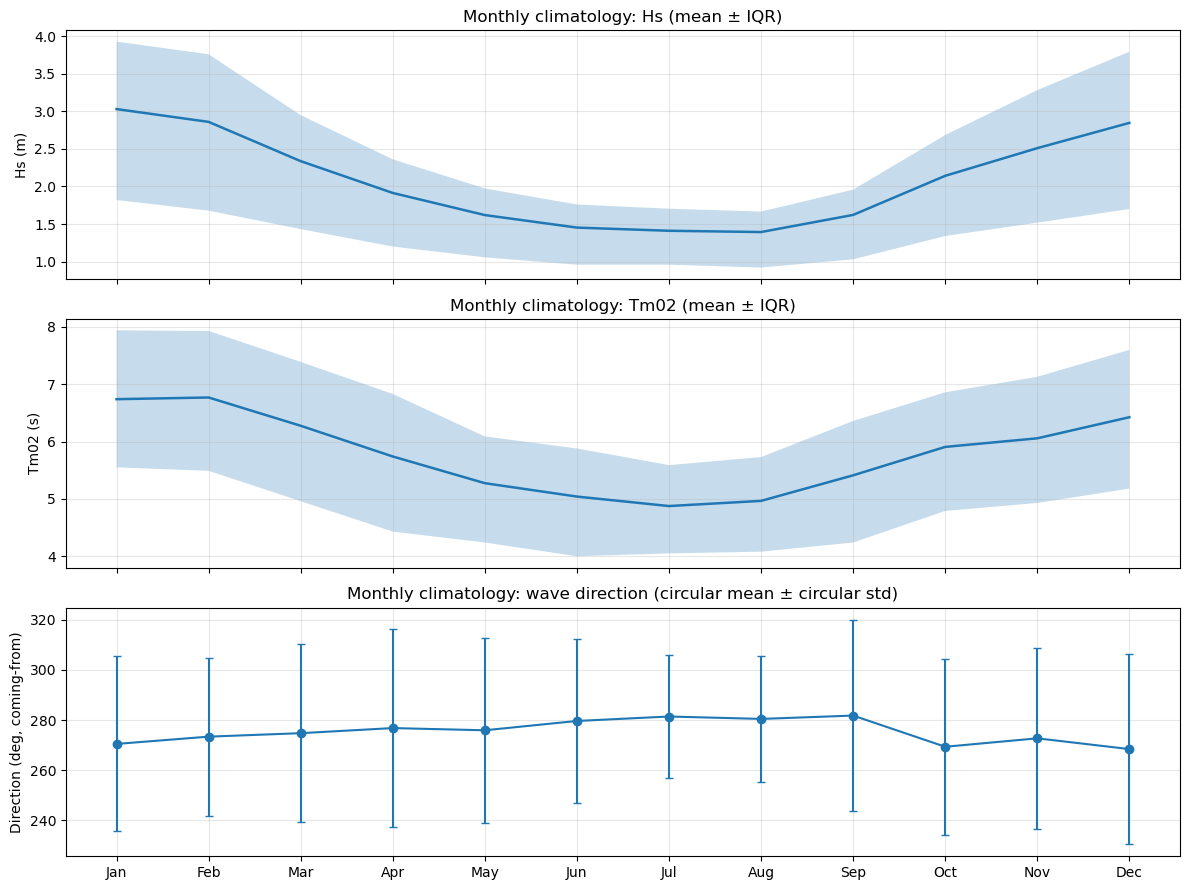

IA.3 — Seasonal climatology (1994–2020)
  Hs peaks in January and is lowest in August.
  Tm02 peaks in February and is lowest in July.
  Direction mean (overall) ≈ 275.5° (coming-from).
  Saved: fig/IA3_seasonal_climatology.png and fig/IA3_seasonal_climatology.csv


In [222]:
# --- IA.3 Seasonal variability: monthly climatology of Hs, Tm02, and direction (mean ± IQR) ---

# inputs
need  = {"hs", "Tm02", "dir"}
if not need.issubset(data.columns):
    raise KeyError(f"IA.3 needs columns {sorted(need)} in `data`.")

df3 = data.loc[start:end, ["hs", "Tm02", "dir"]].copy()
if not isinstance(df3.index, pd.DatetimeIndex):
    raise TypeError("`data` index must be a DatetimeIndex.")

# group by calendar month across all years
g = df3.groupby(df3.index.month)  # 1..12

# numeric climatology for Hs and Tm02
hs_mean = g["hs"].mean()
hs_q25  = g["hs"].quantile(0.25)
hs_q75  = g["hs"].quantile(0.75)

tm_mean = g["Tm02"].mean()
tm_q25  = g["Tm02"].quantile(0.25)
tm_q75  = g["Tm02"].quantile(0.75)

n_samples = g.size()

# circular climatology for direction (vectorised; stable across pandas versions)
dd = df3[["dir"]].copy()
m = dd["dir"].notna()
dd.loc[m, "sin"] = np.sin(np.deg2rad(dd.loc[m, "dir"]))
dd.loc[m, "cos"] = np.cos(np.deg2rad(dd.loc[m, "dir"]))

dg = dd.groupby(dd.index.month)
sin_mean = dg["sin"].mean()
cos_mean = dg["cos"].mean()
n_dir    = dg["dir"].count()

R = np.hypot(sin_mean, cos_mean)                                  # mean resultant length
dir_mean = (np.degrees(np.arctan2(sin_mean, cos_mean)) + 360) % 360
dir_cstd = np.degrees(np.sqrt(np.maximum(0.0, -2.0 * np.log(np.clip(R, 1e-12, 1.0)))))  # circular std (deg)

# unwrap monthly direction around overall circular mean to avoid 0/360 jump
sin_all = np.sin(np.deg2rad(df3["dir"].dropna())).mean()
cos_all = np.cos(np.deg2rad(df3["dir"].dropna())).mean()
overall_dir = (np.degrees(np.arctan2(sin_all, cos_all)) + 360) % 360
dir_mean_unwrapped = overall_dir + ((dir_mean - overall_dir + 540.0) % 360.0 - 180.0)

# assemble single DataFrame and ensure months 1..12 exist and in order
clim = pd.DataFrame({
    "hs_mean": hs_mean,
    "hs_q25":  hs_q25,
    "hs_q75":  hs_q75,
    "Tm02_mean": tm_mean,
    "Tm02_q25":  tm_q25,
    "Tm02_q75":  tm_q75,
    "N_samples": n_samples,
    "dir_mean": dir_mean,
    "R": R,
    "dir_cstd": dir_cstd,
    "n_dir": n_dir,
    "dir_mean_unwrapped": dir_mean_unwrapped,
}).reindex(range(1, 13))
clim.index.name = "month"
clim["month_name"] = pd.to_datetime(clim.index, format="%m").month_name().str.slice(0, 3)

# save numeric table
clim.to_csv("fig/IA3_seasonal_climatology.csv", float_format="%.3f")

# plot
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
x = np.arange(1, 13)
labels = clim["month_name"].values

# Hs: mean ± IQR
ax = axes[0]
ax.plot(x, clim["hs_mean"].values, lw=1.8)
ax.fill_between(x, clim["hs_q25"].values, clim["hs_q75"].values, alpha=0.25)
ax.set_ylabel("Hs (m)")
ax.grid(alpha=0.3)
ax.set_title("Monthly climatology: Hs (mean ± IQR)")

# Tm02: mean ± IQR
ax = axes[1]
ax.plot(x, clim["Tm02_mean"].values, lw=1.8)
ax.fill_between(x, clim["Tm02_q25"].values, clim["Tm02_q75"].values, alpha=0.25)
ax.set_ylabel("Tm02 (s)")
ax.grid(alpha=0.3)
ax.set_title("Monthly climatology: Tm02 (mean ± IQR)")

# Direction: circular mean ± circular std (unwrapped for continuity)
ax = axes[2]
y = clim["dir_mean_unwrapped"].values
yerr = clim["dir_cstd"].values
ax.errorbar(x, y, yerr=yerr, fmt="-o", lw=1.5, capsize=3)
pad = 5.0
ymin, ymax = np.nanmin(y - yerr), np.nanmax(y + yerr)
ax.set_ylim(ymin - pad, ymax + pad)
ax.set_ylabel("Direction (deg, coming-from)")
ax.grid(alpha=0.3)
ax.set_title("Monthly climatology: wave direction (circular mean ± circular std)")
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.tight_layout()
plt.savefig("fig/IA3_seasonal_climatology.png", dpi=200, bbox_inches="tight")
plt.show()

# quick textual summary
hs_max_mo = int(clim["hs_mean"].idxmax())
hs_min_mo = int(clim["hs_mean"].idxmin())
tm_max_mo = int(clim["Tm02_mean"].idxmax())
tm_min_mo = int(clim["Tm02_mean"].idxmin())
print("IA.3 — Seasonal climatology (1994–2020)")
print(f"  Hs peaks in {pd.to_datetime(hs_max_mo, format='%m').month_name()} "
      f"and is lowest in {pd.to_datetime(hs_min_mo, format='%m').month_name()}.")
print(f"  Tm02 peaks in {pd.to_datetime(tm_max_mo, format='%m').month_name()} "
      f"and is lowest in {pd.to_datetime(tm_min_mo, format='%m').month_name()}.")
print(f"  Direction mean (overall) ≈ {overall_dir:.1f}° (coming-from).")
print("  Saved: fig/IA3_seasonal_climatology.png and fig/IA3_seasonal_climatology.csv")


**Q: Do you observe any seasonal trends in wave height, period, or direction? If so, why?**


### Results

**Significant wave height, $H_s$.** Clear winter maximum and summer minimum. IQR widens in winter and narrows in summer.  
**Interpretation.** Boreal-winter extratropical cyclones increase wind speed and fetch over the open North Atlantic, augmenting wind-sea and incoming swell towards south Brittany. Summer conditions are dominated by weaker winds and shorter fetch, so mean $H_s$ decreases and variability contracts. Because wave energy density scales as
$$
E=\tfrac{1}{8}\,\rho g\,H_s^2,
$$
higher winter $H_s$ implies markedly greater wave energy arriving at the site.

**Mean zero-crossing period, $T_{m02}$.** Co-varies with $H_s$: longer in winter, shorter in summer.  
**Interpretation.** Winter storms generate longer-period swell over long fetches. Deep-water dispersion $\big(L\approx gT^2/2\pi,\ c_g \approx gT/4\pi\big)$ favours the far-field propagation of longer-period energy into the Bay of Biscay. In summer, local wind-sea contribution increases and typical periods shorten.

### Wave direction (coming-from, clockwise from North)

**Convention.** $0^\circ=\mathrm{N},\ 90^\circ=\mathrm{E},\ 180^\circ=\mathrm{S},\ 270^\circ=\mathrm{W}$.

**Seasonal pattern.** The monthly circular mean increases from winter ($\sim 270^\circ$) to summer ($\sim 280^\circ$), then decreases again in autumn.

**Interpretation** Larger angles imply a more westerly approach. Thus, waves are slightly more **W–WSW** in summer and shift a little toward **SW** in winter.

**Regional context.** Along the southern Brittany–Bay of Biscay sector, the summer expansion of the Azores High favours a more zonal (westerly) approach at the shelf break. In winter, frequent lows entering the Bay introduce a modest southerly component in the incident swell, yielding the observed decrease in direction angle.

**Dispersion note.** The vertical bars are circular standard deviations (spread of hourly directions), not standard errors. They are of similar magnitude across months, so the dataset does **not** support a strong seasonal change in directional spread.

## Implications

- **Operations.** Highest loads and sea states occur in winter months; scheduling for installation or maintenance is more feasible in late spring–summer.  
- **Variability.** Broad winter IQRs indicate stronger interannual modulation of sea states; design and planning should not rely on a single “typical” winter value.  
- **Directionality.** The prevailing W–WSW approach is stable enough to justify directional binning around that sector for further analyses and for extreme value modelling in Part II.

## Notes and caveats

- Monthly means smooth synoptic extremes; use EVA for design loads.  
- Direction statistics use circular metrics; reported means reflect modal approach rather than arithmetic averages near $0/360^\circ$.  
- The site is predominantly deep water, so seasonal patterns reflect atmospheric forcing and basin geometry rather than depth-limited effects.


---
### I.A.4. Mean Wind and Current Conditions

We will also evaluate the wind and current conditions by plotting rose diagrams of their respective velocities and directions.


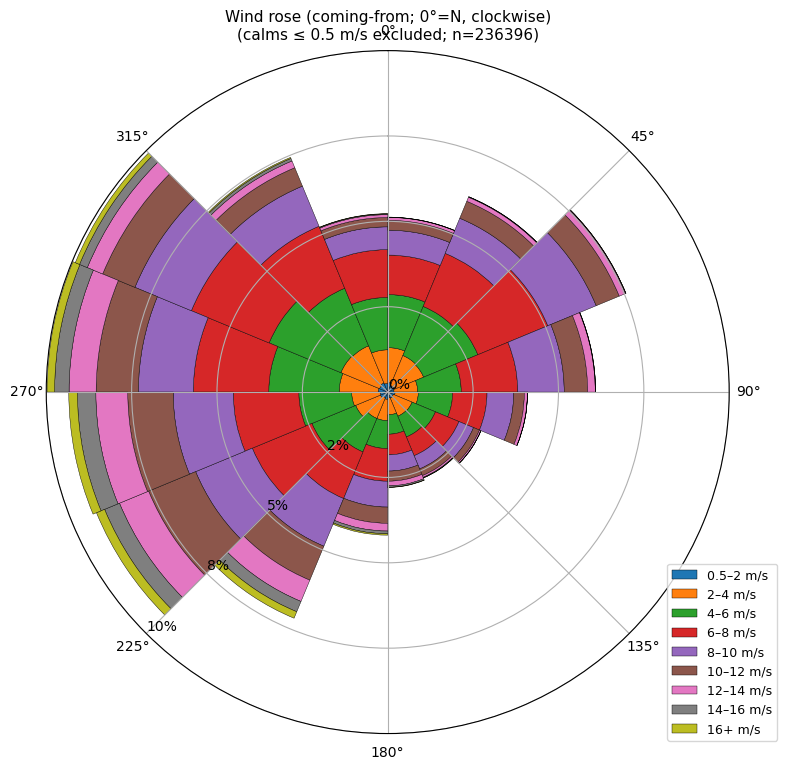

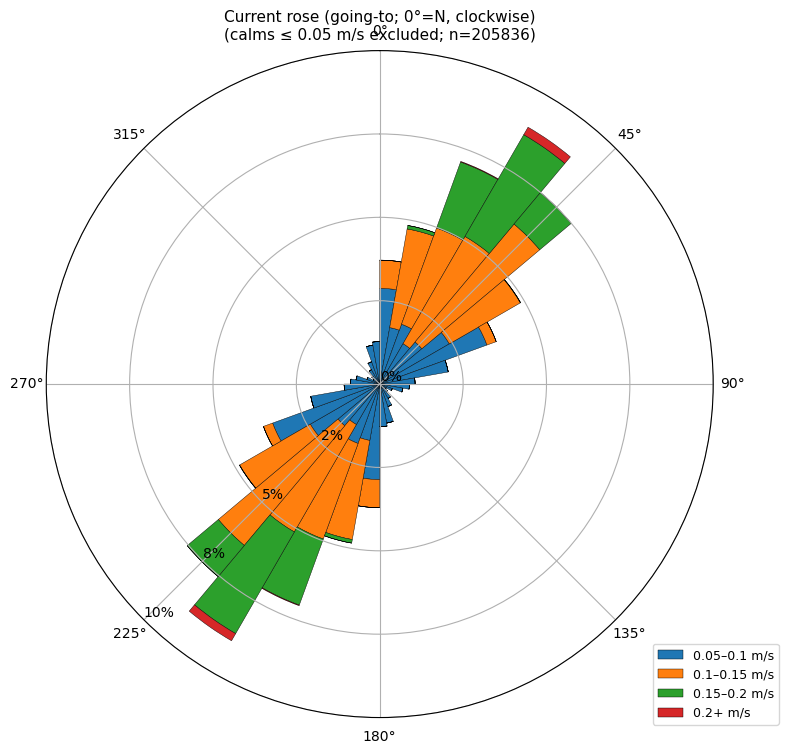

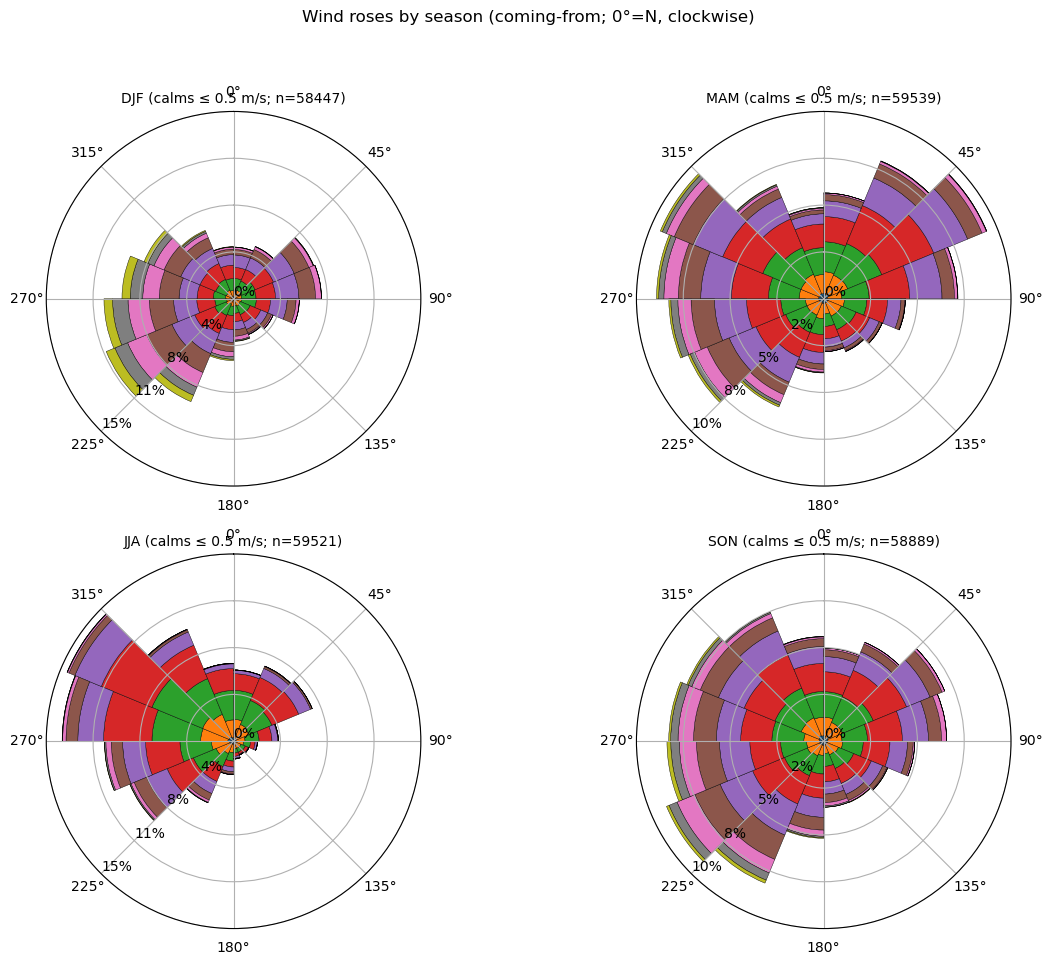

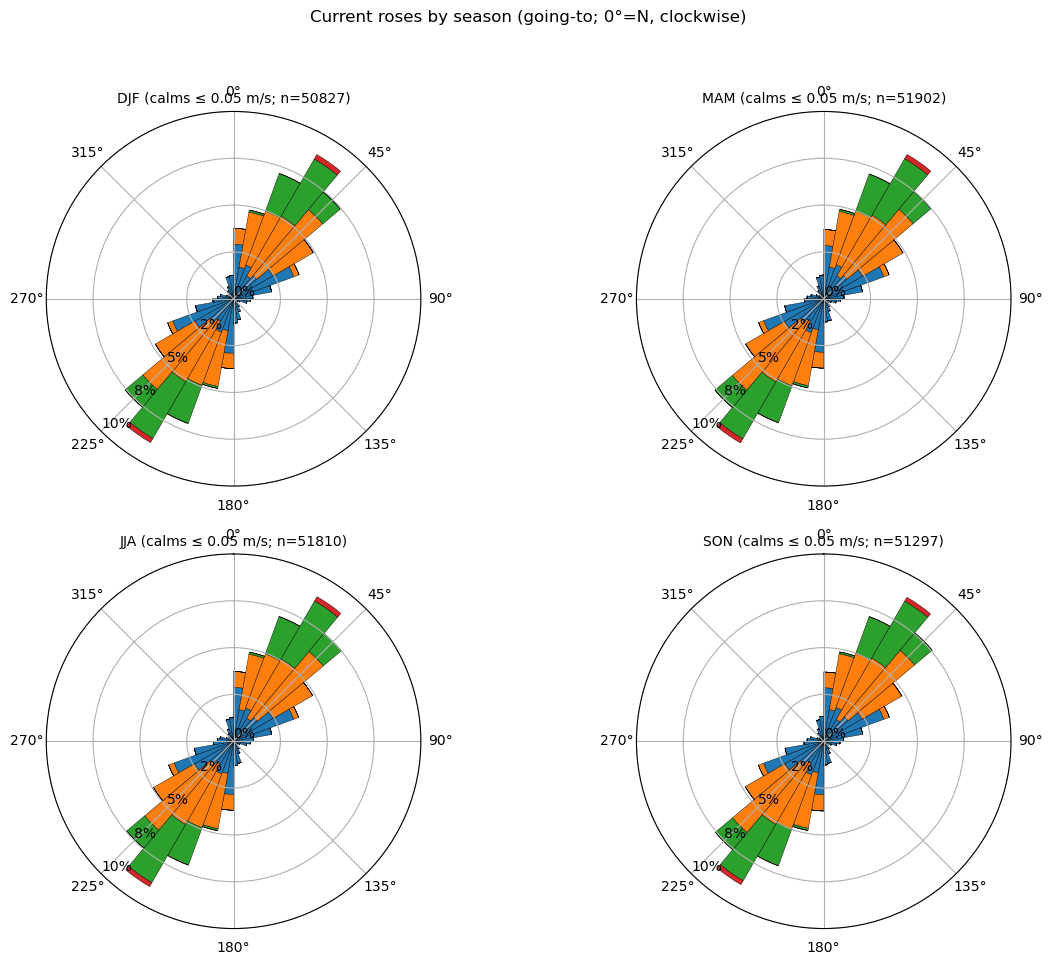


IA.4 — Seasonal means, wind (coming-from)
season mean_speed_mps mean_dir_deg     n
   DJF          8.669        266.3 58488
   MAM          6.953        321.1 59616
   JJA          5.997        302.6 59616
   SON          7.306        287.5 58968

IA.4 — Seasonal means, current (going-to)
season mean_speed_mps mean_dir_deg     n
   DJF          0.096        211.3 58488
   MAM          0.096         28.3 59616
   JJA          0.096        228.5 59616
   SON          0.096         19.0 58968
IA.4 — Mean conditions (1994–2020)
      kind    level group  mean_speed_mps  mean_dir_deg         n
0     wind  overall   all            7.22        296.56 236688.00
5  current  overall   all            0.10        285.24 236688.00

Saved figures:
  fig/IA4_wind_rose.png
  fig/IA4_current_rose.png
  fig/IA4_wind_rose_seasons.png
  fig/IA4_current_rose_seasons.png
Saved table: fig/IA4_mean_wind_current_stats.csv


In [223]:
# --- IA.4 Mean wind and current conditions: roses + means (overall, seasonal) ---
# -----------------------
# Config
# -----------------------
# Calm thresholds used for ROSES only (kept in means table for reference)
CALM_WIND = 0.5    # m/s
CALM_CURR = 0.05   # m/s

# Speed bins
# Wind: [0.5–2), 2–4, 4–6, …, ≥16 m/s
WIND_BINS = np.r_[0.5, np.arange(2, 18, 2), np.inf]
# Currents: [0.05–0.1), 0.1–0.2, 0.2–0.3, 0.3–0.5, ≥0.5 m/s
CURR_BINS = np.array([0.05, 0.10, 0.15, 0.2, np.inf])

# Direction sectors
WIND_SECTORS = 16   # 22.5°
CURR_SECTORS = 36   # 10°

# Date window to match the project
# -----------------------
# Helpers
# -----------------------
def season_label(month):
    # DJF, MAM, JJA, SON
    if month in (12, 1, 2):
        return "DJF"
    if month in (3, 4, 5):
        return "MAM"
    if month in (6, 7, 8):
        return "JJA"
    return "SON"

def rose_counts(dir_deg, spd, spd_bins, sectors=16, calm_thresh=0.0):
    """
    Return stacked counts per direction sector and speed bin, plus metadata.
    Directions: degrees, 0°=N, clockwise positive.
    Excludes values with spd <= calm_thresh.
    """
    mask = np.isfinite(dir_deg) & np.isfinite(spd) & (spd > calm_thresh)
    d = np.asarray(dir_deg)[mask] % 360.0
    s = np.asarray(spd)[mask]

    if d.size == 0:
        counts = np.zeros((sectors, len(spd_bins)-1), dtype=int)
        return counts, np.array([]), 0

    width = 360.0 / sectors
    sector_idx = np.floor(d / width).astype(int)
    sector_idx[sector_idx == sectors] = sectors - 1

    bin_idx = np.digitize(s, spd_bins) - 1
    bin_idx = np.clip(bin_idx, 0, len(spd_bins)-2)

    counts = np.zeros((sectors, len(spd_bins)-1), dtype=int)
    for k in range(d.size):
        counts[sector_idx[k], bin_idx[k]] += 1

    return counts, mask, d.size  # d.size = included samples after calm filter

def plot_rose(dir_deg, spd, spd_bins, fname, title, calm_thresh=0.0, sectors=16):
    """
    Polar stacked-bar rose. Heights are percentages of included samples.
    Direction convention: 0° at North, clockwise positive.
    """
    counts, mask, n_used = rose_counts(dir_deg, spd, spd_bins, sectors, calm_thresh)
    if n_used == 0:
        print(f"{title}: no data above calm threshold.")
        return

    sector_totals = counts.sum(axis=1).astype(float)
    sector_totals[sector_totals == 0] = 1.0
    frac = counts / sector_totals[:, None]
    pct_sector = 100.0 * counts.sum(axis=1) / n_used

    theta = np.deg2rad(np.arange(0, 360, 360/sectors))
    width = 2.0 * np.pi / sectors

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    bottoms = np.zeros(sectors)
    labels = []
    for j in range(len(spd_bins)-1):
        label = f"{spd_bins[j]:g}–{spd_bins[j+1]:g} m/s" if np.isfinite(spd_bins[j+1]) else f"{spd_bins[j]:g}+ m/s"
        labels.append(label)
        heights = pct_sector * frac[:, j]
        ax.bar(theta, heights, width=width, bottom=bottoms, align="edge",
               edgecolor="black", linewidth=0.3)
        bottoms += heights

    ax.set_rlabel_position(225)
    rmax = max(5.0, np.ceil(bottoms.max() / 5.0) * 5.0)
    ax.set_ylim(0, rmax)
    ax.set_yticks(np.linspace(0, rmax, 5))
    ax.set_yticklabels([f"{v:.0f}%" for v in np.linspace(0, rmax, 5)])

    ax.set_title(title + f"\n(calms ≤ {calm_thresh} m/s excluded; n={n_used})",
                 va="bottom", fontsize=11)
    ax.legend(labels, loc="lower left", bbox_to_anchor=(0.9, -0.02),
              frameon=True, fontsize=9)

    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

def mean_table(dir_deg, spd, label, calm_thresh=None):
    """
    Mean speed (arithmetic) and mean direction (circular) overall and by season.
    Directions in degrees [0, 360).
    calm_thresh listed for reference; does not alter means.
    """
    idx = data.loc[start:end].index
    df = pd.DataFrame({"spd": spd.loc[idx], "dir": dir_deg.loc[idx]})
    df["season"] = df.index.month.map(season_label)

    def agg(g):
        return pd.Series({
            "mean_speed_mps": g["spd"].mean(),
            "mean_dir_deg": circmean_deg(g["dir"]),
            "n": g["dir"].count()
        })

    overall = agg(df)
    by_season = df.groupby("season", sort=False).apply(agg)

    overall.name = label
    out = {"overall": overall.to_frame().T, "season": by_season}
    out["meta"] = {"calm_threshold_listed_only_mps": calm_thresh}
    return out

# -----------------------
# Prepare series and conventions
# -----------------------
# Wind: already "coming-from" via zmcomp2metconv
wspd = data["wspd"].copy()
wdir_from = data["wdir"].copy()  # coming-from, 0°=N, clockwise

# Currents: convert to "going-to" for the rose
if {"cspd", "cdir"}.issubset(data.columns):
    cspd = data["cspd"].copy()
    cdir_to = (data["cdir"] + 180.0) % 360.0
else:
    cspd = None
    cdir_to = None

# Restrict to analysis window
sel = slice(start, end)
wspd = wspd.loc[sel]
wdir_from = wdir_from.loc[sel]
if cspd is not None:
    cspd = cspd.loc[sel]
    cdir_to = cdir_to.loc[sel]

# -----------------------
# 1) Full-period roses
# -----------------------
plot_rose(
    dir_deg=wdir_from, spd=wspd, spd_bins=WIND_BINS,
    fname="fig/IA4_wind_rose.png",
    title="Wind rose (coming-from; 0°=N, clockwise)",
    calm_thresh=CALM_WIND, sectors=WIND_SECTORS
)

if cspd is not None:
    plot_rose(
        dir_deg=cdir_to, spd=cspd, spd_bins=CURR_BINS,
        fname="fig/IA4_current_rose.png",
        title="Current rose (going-to; 0°=N, clockwise)",
        calm_thresh=CALM_CURR, sectors=CURR_SECTORS
    )

# -----------------------
# 2) Seasonal roses (DJF, MAM, JJA, SON)
# -----------------------
def plot_rose_seasons(dir_series, spd_series, spd_bins, calm_thresh, sectors, title_base, fname):
    seasons = ["DJF", "MAM", "JJA", "SON"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw=dict(polar=True))
    axes = axes.ravel()
    for i, s in enumerate(seasons):
        sel = dir_series.index.map(lambda t: season_label(t.month) == s)
        d = dir_series[sel]
        v = spd_series[sel]
        counts, mask, n_used = rose_counts(d.values, v.values, spd_bins, sectors, calm_thresh)
        theta = np.deg2rad(np.arange(0, 360, 360/sectors))
        width = 2.0 * np.pi / sectors

        ax = axes[i]
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)

        if n_used == 0:
            ax.set_title(f"{s} (n=0)")
            continue

        sector_totals = counts.sum(axis=1).astype(float)
        sector_totals[sector_totals == 0] = 1.0
        frac = counts / sector_totals[:, None]
        pct_sector = 100.0 * counts.sum(axis=1) / n_used

        bottoms = np.zeros(sectors)
        for j in range(len(spd_bins)-1):
            heights = pct_sector * frac[:, j]
            ax.bar(theta, heights, width=width, bottom=bottoms, align="edge",
                   edgecolor="black", linewidth=0.3)
            bottoms += heights

        ax.set_rlabel_position(225)
        rmax = max(5.0, np.ceil(bottoms.max() / 5.0) * 5.0)
        ax.set_ylim(0, rmax)
        ax.set_yticks(np.linspace(0, rmax, 5))
        ax.set_yticklabels([f"{v:.0f}%" for v in np.linspace(0, rmax, 5)])
        ax.set_title(f"{s} (calms ≤ {calm_thresh} m/s; n={n_used})", fontsize=10)

    fig.suptitle(title_base, y=0.98)
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

plot_rose_seasons(
    wdir_from, wspd, WIND_BINS, CALM_WIND, WIND_SECTORS,
    "Wind roses by season (coming-from; 0°=N, clockwise)",
    "fig/IA4_wind_rose_seasons.png"
)

if cspd is not None:
    plot_rose_seasons(
        cdir_to, cspd, CURR_BINS, CALM_CURR, CURR_SECTORS,
        "Current roses by season (going-to; 0°=N, clockwise)",
        "fig/IA4_current_rose_seasons.png"
    )

# -----------------------
# 3) Mean conditions tables and CSV
# -----------------------
wind_stats = mean_table(wdir_from, wspd, label="wind", calm_thresh=CALM_WIND)
if cspd is not None:
    curr_stats = mean_table(cdir_to, cspd, label="current", calm_thresh=CALM_CURR)

frames = []
wind_overall = wind_stats["overall"].assign(kind="wind")
wind_season  = wind_stats["season"].assign(kind="wind", level="season").reset_index().rename(columns={"season":"group"})
frames += [wind_overall.assign(level="overall", group="all"), wind_season]

if cspd is not None:
    curr_overall = curr_stats["overall"].assign(kind="current")
    curr_season  = curr_stats["season"].assign(kind="current", level="season").reset_index().rename(columns={"season":"group"})
    frames += [curr_overall.assign(level="overall", group="all"), curr_season]

stats_df = pd.concat(frames, ignore_index=True)
stats_df = stats_df[["kind", "level", "group", "mean_speed_mps", "mean_dir_deg", "n"]]
stats_df.to_csv("fig/IA4_mean_wind_current_stats.csv", index=False, float_format="%.3f")

# Print seasonal values for wind and current

season_order = CategoricalDtype(["DJF", "MAM", "JJA", "SON"], ordered=True)

def print_seasonals(kind_label, dir_note):
    df = stats_df.query("kind == @kind_label and level == 'season'").copy()
    df["group"] = df["group"].astype(season_order)
    df = df.sort_values("group")
    print(f"\nIA.4 — Seasonal means, {kind_label} ({dir_note})")
    print(df[["group", "mean_speed_mps", "mean_dir_deg", "n"]]
          .rename(columns={"group": "season"})
          .to_string(index=False,
                     formatters={
                         "mean_speed_mps": lambda v: f"{v:.3f}",
                         "mean_dir_deg":  lambda v: f"{v:.1f}",
                         "n":             lambda v: f"{int(v)}"
                     }))

print_seasonals("wind", "coming-from")
print_seasonals("current", "going-to")

print("IA.4 — Mean conditions (1994–2020)")
print(stats_df.query("level == 'overall'"))
print("\nSaved figures:")
print("  fig/IA4_wind_rose.png")
if cspd is not None:
    print("  fig/IA4_current_rose.png")
print("  fig/IA4_wind_rose_seasons.png")
if cspd is not None:
    print("  fig/IA4_current_rose_seasons.png")
print("Saved table: fig/IA4_mean_wind_current_stats.csv")

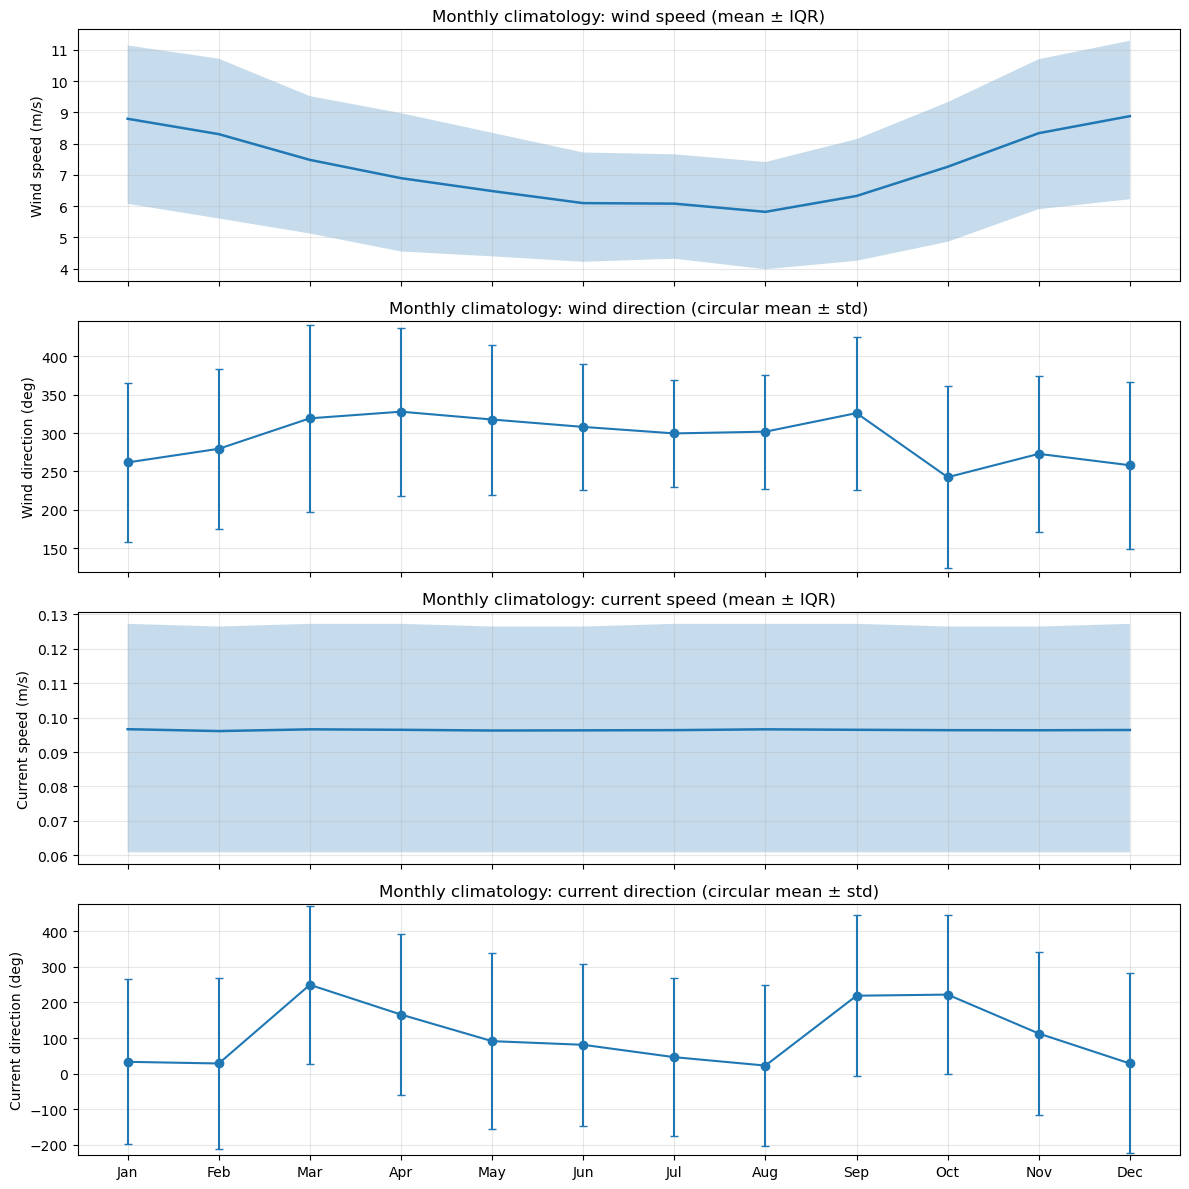

IA.4 — Monthly wind/current climatology saved to fig/IA4_wind_current_monthly_climatology.(csv|png)
  Included both wind and current statistics.


In [224]:
# --- IA.4 Monthly climatology: wind & current (mean ± IQR; direction circular mean ± std) ---
need_wind = {"wspd", "wdir"}
curr_need = {"cspd", "cdir"}
missing = need_wind - set(data.columns)
if missing:
    raise KeyError(f"IA.4 monthly climatology missing columns {sorted(missing)} in `data`.")

has_currents = curr_need.issubset(data.columns)
cols = ["wspd", "wdir"] + (["cspd", "cdir"] if has_currents else [])
df_wc = data.loc[start:end, cols].copy()
if not isinstance(df_wc.index, pd.DatetimeIndex):
    raise TypeError("`data` index must be a DatetimeIndex.")

months = pd.Index(range(1, 13), name="month")
month_group = df_wc.groupby(df_wc.index.month)

wspd_mean = month_group["wspd"].mean().reindex(months)
wspd_q25 = month_group["wspd"].quantile(0.25).reindex(months)
wspd_q75 = month_group["wspd"].quantile(0.75).reindex(months)

if has_currents:
    cspd_mean = month_group["cspd"].mean().reindex(months)
    cspd_q25 = month_group["cspd"].quantile(0.25).reindex(months)
    cspd_q75 = month_group["cspd"].quantile(0.75).reindex(months)

def _direction_series(series):
    df = series.to_frame(name="theta")
    mask = df["theta"].notna()
    df.loc[mask, "sin"] = np.sin(np.deg2rad(df.loc[mask, "theta"]))
    df.loc[mask, "cos"] = np.cos(np.deg2rad(df.loc[mask, "theta"]))
    group = df.groupby(df.index.month)
    sin_mean = group["sin"].mean()
    cos_mean = group["cos"].mean()
    counts = group["theta"].count()
    R = np.hypot(sin_mean, cos_mean)
    mean = (np.degrees(np.arctan2(sin_mean, cos_mean)) + 360.0) % 360.0
    cstd = np.degrees(np.sqrt(np.maximum(0.0, -2.0 * np.log(np.clip(R, 1e-12, 1.0)))))
    mean = mean.where(counts > 0)
    cstd = cstd.where(counts > 0)
    R = R.where(counts > 0)
    return mean, cstd, R, counts

wdir_mean, wdir_cstd, wdir_R, wdir_n = _direction_series(df_wc["wdir"])
wdir_mean = wdir_mean.reindex(months)
wdir_cstd = wdir_cstd.reindex(months)
wdir_R = wdir_R.reindex(months)
wdir_n = wdir_n.reindex(months)
wdir_raw = df_wc["wdir"].dropna()
if wdir_raw.empty:
    wind_overall_dir = np.nan
    wdir_mean_unwrapped = wdir_mean.copy()
else:
    sin_all = np.sin(np.deg2rad(wdir_raw)).mean()
    cos_all = np.cos(np.deg2rad(wdir_raw)).mean()
    wind_overall_dir = (np.degrees(np.arctan2(sin_all, cos_all)) + 360.0) % 360.0
    wdir_mean_unwrapped = wind_overall_dir + ((wdir_mean - wind_overall_dir + 540.0) % 360.0 - 180.0)

if has_currents:
    cdir_mean, cdir_cstd, cdir_R, cdir_n = _direction_series(df_wc["cdir"])
    cdir_mean = cdir_mean.reindex(months)
    cdir_cstd = cdir_cstd.reindex(months)
    cdir_R = cdir_R.reindex(months)
    cdir_n = cdir_n.reindex(months)
    cdir_raw = df_wc["cdir"].dropna()
    if cdir_raw.empty:
        curr_overall_dir = np.nan
        cdir_mean_unwrapped = cdir_mean.copy()
    else:
        sin_all = np.sin(np.deg2rad(cdir_raw)).mean()
        cos_all = np.cos(np.deg2rad(cdir_raw)).mean()
        curr_overall_dir = (np.degrees(np.arctan2(sin_all, cos_all)) + 360.0) % 360.0
        cdir_mean_unwrapped = curr_overall_dir + ((cdir_mean - curr_overall_dir + 540.0) % 360.0 - 180.0)

clim = pd.DataFrame(index=months)
clim["month_name"] = pd.to_datetime(clim.index, format="%m").month_name().str.slice(0, 3)
clim["wspd_mean"] = wspd_mean
clim["wspd_q25"] = wspd_q25
clim["wspd_q75"] = wspd_q75
clim["wdir_mean"] = wdir_mean
clim["wdir_mean_unwrapped"] = wdir_mean_unwrapped
clim["wdir_cstd"] = wdir_cstd
clim["wdir_R"] = wdir_R
clim["wdir_n"] = wdir_n

if has_currents:
    clim["cspd_mean"] = cspd_mean
    clim["cspd_q25"] = cspd_q25
    clim["cspd_q75"] = cspd_q75
    clim["cdir_mean"] = cdir_mean
    clim["cdir_mean_unwrapped"] = cdir_mean_unwrapped
    clim["cdir_cstd"] = cdir_cstd
    clim["cdir_R"] = cdir_R
    clim["cdir_n"] = cdir_n

clim.to_csv("fig/IA4_wind_current_monthly_climatology.csv", float_format="%.3f")

x = np.arange(1, 13)
labels = clim["month_name"].tolist()
n_rows = 4 if has_currents else 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 3 * n_rows), sharex=True)
axes = np.atleast_1d(axes)

ax = axes[0]
ax.plot(x, clim["wspd_mean"], lw=1.8)
ax.fill_between(x, clim["wspd_q25"], clim["wspd_q75"], alpha=0.25)
ax.set_ylabel("Wind speed (m/s)")
ax.set_title("Monthly climatology: wind speed (mean ± IQR)")
ax.grid(alpha=0.3)

ax = axes[1]
y = clim["wdir_mean_unwrapped"].to_numpy()
yerr = clim["wdir_cstd"].to_numpy()
ax.errorbar(x, y, yerr=yerr, fmt="-o", capsize=3, lw=1.5)
if np.isfinite(y).any():
    lower = y - np.nan_to_num(yerr, nan=0.0)
    upper = y + np.nan_to_num(yerr, nan=0.0)
    finite = np.isfinite(lower) & np.isfinite(upper)
    if finite.any():
        pad = 5.0
        ax.set_ylim(lower[finite].min() - pad, upper[finite].max() + pad)
ax.set_ylabel("Wind direction (deg)")
ax.set_title("Monthly climatology: wind direction (circular mean ± std)")
ax.grid(alpha=0.3)

if has_currents:
    ax = axes[2]
    ax.plot(x, clim["cspd_mean"], lw=1.8)
    ax.fill_between(x, clim["cspd_q25"], clim["cspd_q75"], alpha=0.25)
    ax.set_ylabel("Current speed (m/s)")
    ax.set_title("Monthly climatology: current speed (mean ± IQR)")
    ax.grid(alpha=0.3)

    ax = axes[3]
    y = clim["cdir_mean_unwrapped"].to_numpy()
    yerr = clim["cdir_cstd"].to_numpy()
    ax.errorbar(x, y, yerr=yerr, fmt="-o", capsize=3, lw=1.5)
    if np.isfinite(y).any():
        lower = y - np.nan_to_num(yerr, nan=0.0)
        upper = y + np.nan_to_num(yerr, nan=0.0)
        finite = np.isfinite(lower) & np.isfinite(upper)
        if finite.any():
            pad = 5.0
            ax.set_ylim(lower[finite].min() - pad, upper[finite].max() + pad)
    ax.set_ylabel("Current direction (deg)")
    ax.set_title("Monthly climatology: current direction (circular mean ± std)")
    ax.grid(alpha=0.3)

axes[-1].set_xticks(x)
axes[-1].set_xticklabels(labels)

plt.tight_layout()
plt.savefig("fig/IA4_wind_current_monthly_climatology.png", dpi=200, bbox_inches="tight")
plt.show()

print("IA.4 — Monthly wind/current climatology saved to fig/IA4_wind_current_monthly_climatology.(csv|png)")
if has_currents:
    print("  Included both wind and current statistics.")
else:
    print("  Current data unavailable; plotted wind only.")

**Q: What are the mean conditions (e.g. velocity and direction)? (if you have time: do you observe any seasonal variability?)**

### IA.4  Interpretation of wind and current conditions


**Answer.** Winds are W-WNW year-round and strongest in winter (overall mean 7.22 m/s; DJF mean 8.67 m/s). Currents are weak (about 0.10 m/s) and dominantly tidal along a NE-SW axis, so the overall mean direction is not physically representative.


---


### Data basis and conventions


- Period analysed: 1994-2020.  
- Calms excluded in roses: wind $<0.5$ m/s, current $<0.05$ m/s.  
- Wind: **coming-from**; Current: **going-to**; $0^\circ=\text{N}$, clockwise.  
- Bins used: wind speeds $[0.5,2),[2,4),\ldots,\ge 16$ m/s; current speeds $[0.05,0.10),[0.10,0.15),[0.15,0.20),\ge 0.20$ m/s; wind sectors $22.5^\circ$; current sectors $10^\circ$.


---


### Summary statistics


**Overall means (1994-2020)**


| Variable | Mean speed | Mean direction |
|---|---:|---:|
| Wind (coming-from) | 7.22 m/s | 296.6 |
| Current (going-to) | 0.096 m/s | 285.2* |


\*For reversing tidal currents, a single circular mean direction is not physically informative.


**Seasonal means**


| Season | Wind speed (m/s) | Wind dir (deg) | Current speed (m/s) | Current dir (deg)* |
|---|---:|---:|---:|---:|
| DJF | 8.67 | 266.3 | 0.096 | 211.3 |
| MAM | 6.95 | 321.1 | 0.096 | 28.3 |
| JJA | 6.00 | 302.6 | 0.096 | 228.5 |
| SON | 7.31 | 287.5 | 0.096 | 19.0 |


\*Seasonal current means are shown for completeness but the roses indicate a bidirectional tidal regime.


---


### Wind climate: what the roses show


- **Directionality.** Dominant **W-WNW** approach. Seasonal veer is modest: closer to **W** in winter (DJF $\sim266^\circ$), rotating towards **WNW** in spring and summer (MAM-JJA $\sim321^\circ$ to $\sim303^\circ$), then easing back in autumn (SON $\sim288^\circ$).
- **Intensity.** Clear seasonal cycle: **DJF > SON > MAM > JJA** by mean speed. The full-period rose shows most occurrences in the **4-12 m/s** bands, with winter contributing the higher **8-14 m/s** fractions.
- **Variability.** Sectoral spread remains broader in MAM/SON than in DJF/JJA, consistent with synoptic variability during shoulder seasons.


---


### Current climate: what the roses show


- **Regime.** Two narrow, opposing **going-to** headings dominate, approximately **NE (30^\circ)** and **SW (210^\circ)**, confirming a reversing tidal signal.
- **Magnitudes.** Most occurrences lie **below 0.30 m/s**; the highest occupied bin is typically **0.15-0.20 m/s**, with scarce excursions beyond. The mean speed of **0.096 m/s** reflects the prevalence of weak flows.
- **Seasonality.** The **axis does not shift** with season, and the speed distribution changes little between DJF and JJA in the roses, highlighting tide-dominated currents with weak seasonal modulation.


---


### Site context notes


- The study area is **south of Lorient (southern Brittany)**, exposed to the **open North Atlantic**. The prevailing **W-WNW** winds align with the basin-scale westerlies and frequent winter cyclones.  
- The **NE-SW** tidal current axis is consistent with coastal geometry that channels reversing flows; without detailed bathymetry/harmonic analysis, treat this as a qualitative inference from the roses.


---


### Caveats and suggested refinements


- **Currents:** Do not use circular means for direction. Prefer a **principal axis** metric and report the **two modal headings** with their shares.  
- **Quantiles:** Add $P_{50}$, $P_{90}$, $P_{95}$ for wind and current speeds to complement the means (e.g., $P_{90}$ wind speed $\approx$ x m/s).  
- **Calms:** Roses exclude calms by design; if calm frequency is relevant to operations, report the calm fraction separately.  
- **Next step:** If needed for design or logistics, compute a tidal ellipse or principal-component axis for the currents, and provide **hour-of-tide** roses to expose phase dependence.



---
### I.A.5. Comparison to Wave Buoy Measurements

We can validate the ResourceCode hindcast data against observations from a nearby wave buoy, for example, from the Candhis website.






**Q: Comparing the hindcast data from ResourceCode to the observations during the time period with overlapping data, what is the RMSD in the wave height, period, and direction between the observations and simulations?**

Candhis 2020 after QC: 15947 rows

IA.5 — Candhis vs ResourceCode (2020, Belle-Île 05602)
               metric  value  N_pairs
          RMSD_Hs (m)  0.388    15947
        RMSD_Tm02 (s)  0.840    15947
RMSD_Dir_THETAM (deg) 21.156    15947


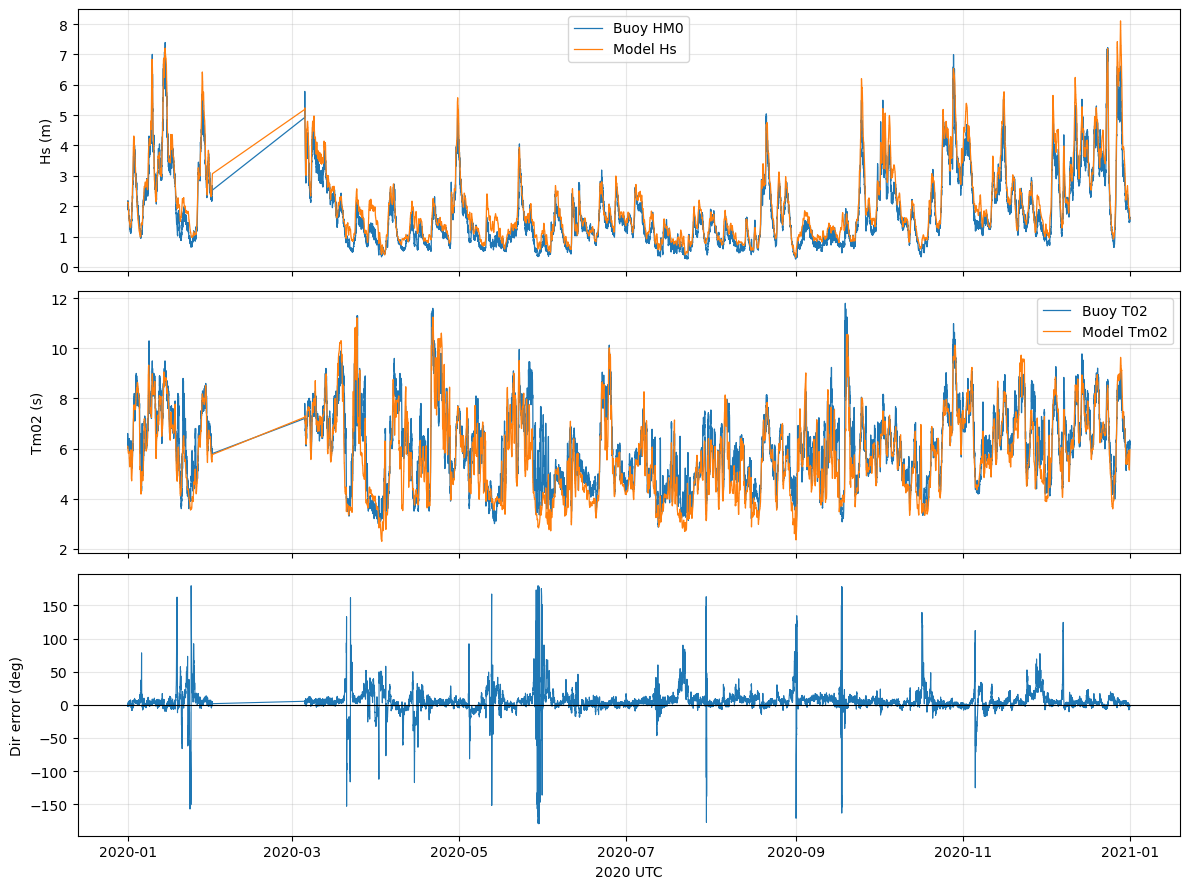

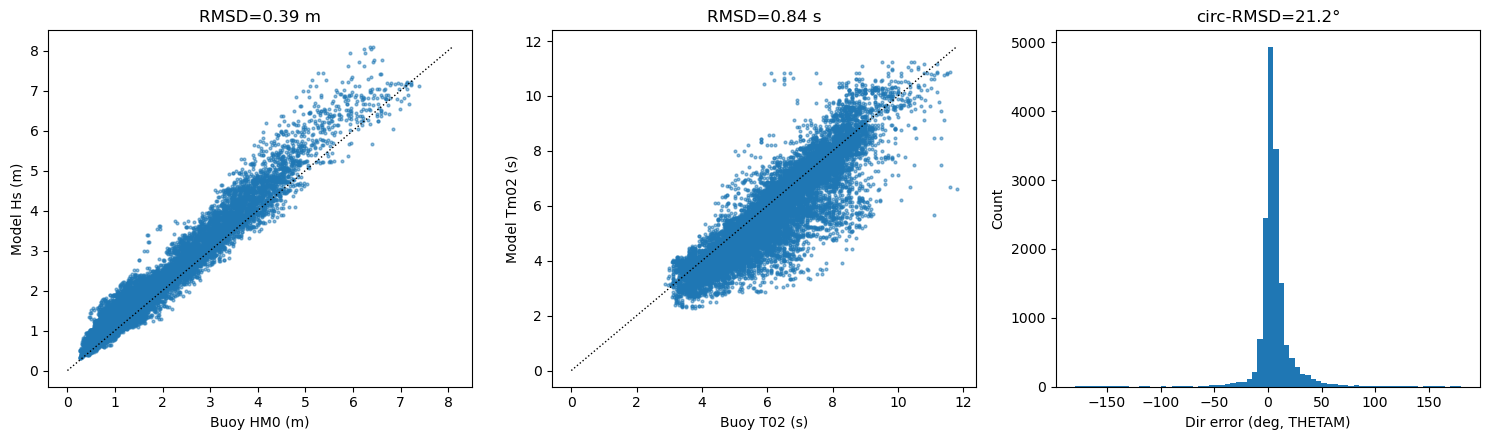

In [225]:
# --- IA.5 — Candhis buoy validation (Belle-Île 05602, year 2020) ---
# Goal: RMSD between ResourceCode hindcast and Candhis observations for Hs, Tm02, and mean direction.
# Notes:
# - Candhis direction: use THETAM (mean, coming-from, true north, clockwise).
# - ResourceCode wave direction assumed coming-from in `data['dir']`. If not, set RC_IS_COMING_FROM=False.
# - Time matching: nearest within ±30 min.
# - QC: drop sentinels (999.*), non-numeric, |SKEW|>0.3, KURT>5, and (if present) non-valid QUALITE.

# ---------- Config ----------
RC_IS_COMING_FROM = True          # set to False if your ResourceCode 'dir' is going-to
TOL = pd.Timedelta("30min")       # matching tolerance
CSV_PATHS = [
    Path("data/Candhis_05602_2020_arch.csv"),     # preferred relative path
    Path("/mnt/data/Candhis_05602_2020_arch.csv") # fallback (chat attachment)
]

# ---------- Utilities ----------
def _first_existing(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError("Candhis 2020 CSV not found at any known path.")

def circ_diff_deg(a_deg, b_deg):
    """Minimal angular difference a-b in degrees in [-180, 180)."""
    d = (a_deg - b_deg + 180.0) % 360.0 - 180.0
    return d

def rmse(a, b):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() == 0:
        return np.nan, 0
    return float(np.sqrt(np.mean((a[m] - b[m])**2))), int(m.sum())

def circ_rmse_deg(a_deg, b_deg):
    """RMS of circular differences in degrees."""
    d = circ_diff_deg(np.asarray(a_deg, float), np.asarray(b_deg, float))
    m = np.isfinite(d)
    if m.sum() == 0:
        return np.nan, 0
    return float(np.sqrt(np.mean(d[m]**2))), int(m.sum())

# ---------- Load Candhis 2020 ----------
candhis_csv = _first_existing(CSV_PATHS)

cand = pd.read_csv(
    candhis_csv,
    sep=";", engine="python",
    parse_dates=["DateHeure"]
)

# Keep only fields needed + QC fields
need_cols = ["DateHeure", "HM0", "T02", "THETAM", "SKEW", "KURT", "QUALITE"]
for c in need_cols:
    if c not in cand.columns:
        # QUALITE may be absent; others must exist
        if c == "QUALITE":
            cand["QUALITE"] = np.nan
        else:
            raise KeyError(f"Missing '{c}' in Candhis CSV.")

# Convert to numeric and mark sentinels (e.g., 999.*) as NaN
num_cols = ["HM0", "T02", "THETAM", "SKEW", "KURT"]
for c in num_cols:
    cand[c] = pd.to_numeric(cand[c], errors="coerce")
    # Drop obvious sentinels like 999, 999.999, etc.
    cand.loc[cand[c] >= 999.0, c] = np.nan

# QC filters
qc = pd.Series(True, index=cand.index)

# 1) Required numeric fields present
qc &= cand["HM0"].notna() & cand["T02"].notna() & cand["THETAM"].notna()

# 2) Physical sanity
qc &= (cand["HM0"] > 0) & (cand["T02"] > 0)

# 3) Distribution checks
#    Drop timestamps with |SKEW| > 0.3 or KURT > 5 (when available)
skew_ok = cand["SKEW"].abs() <= 0.3
kurt_ok = cand["KURT"] <= 5.0
# If SKEW/KURT missing at a row, do not auto-drop for that reason
skew_ok = skew_ok | cand["SKEW"].isna()
kurt_ok = kurt_ok | cand["KURT"].isna()
qc &= skew_ok & kurt_ok

# 4) QUALITE (if present): keep only rows with non-empty labels considered valid
#    Many archive files have QUALITE empty; when populated, typical "good" tags include letters.
if cand["QUALITE"].notna().any():
    # Keep non-empty, non-null strings that are not "M", "NA", or "ERR"
    q = cand["QUALITE"].astype(str).str.strip().str.upper()
    good = ~(q.isna() | (q == "") | q.isin({"M", "NA", "ERR"}))
    qc &= good

cand_qc = cand.loc[qc, ["DateHeure", "HM0", "T02", "THETAM"]].copy()
cand_qc = cand_qc.rename(columns={"DateHeure": "time", "HM0": "hs_obs", "T02": "Tm02_obs", "THETAM": "dir_obs_deg"})
cand_qc["time"] = pd.to_datetime(cand_qc["time"], utc=True)  # TU = UTC
cand_qc = cand_qc.set_index("time").sort_index()

# Restrict strictly to 2020 UTC
start_utc = pd.Timestamp("2020-01-01 00:00:00", tz="UTC")
end_utc   = pd.Timestamp("2020-12-31 23:59:59", tz="UTC")
cand_qc = cand_qc.loc[start_utc:end_utc]

print(f"Candhis 2020 after QC: {len(cand_qc)} rows")

# ---------- Prepare ResourceCode subset for 2020 ----------
# Assumes your earlier cells defined `data` with columns: 'hs', 'Tm02', 'dir' and a DatetimeIndex in UTC or naive-UTC.
if not {"hs", "Tm02", "dir"}.issubset(data.columns):
    raise KeyError("ResourceCode `data` must include ['hs','Tm02','dir'].")

rc = data[["hs", "Tm02", "dir"]].copy()

# Ensure datetime is tz-aware UTC to compare with Candhis TU
if rc.index.tz is None:
    rc.index = rc.index.tz_localize("UTC")

rc_2020 = rc.loc[start_utc:end_utc].copy()
rc_2020 = rc_2020.sort_index()

# Direction convention alignment
if RC_IS_COMING_FROM:
    rc_2020["dir_from_deg"] = rc_2020["dir"] % 360.0
else:
    # Convert going-to -> coming-from to match THETAM
    rc_2020["dir_from_deg"] = (rc_2020["dir"] + 180.0) % 360.0

rc_2020 = rc_2020.rename(columns={"hs": "hs_mod", "Tm02": "Tm02_mod"})

# Time matching (nearest within ±30 min)
left  = cand_qc.reset_index().rename(columns={"time": "t_obs"})
right = rc_2020.reset_index().rename(columns={"index": "t_mod"})

pairs = pd.merge_asof(
    left.sort_values("t_obs"),
    right.sort_values("t_mod"),
    left_on="t_obs",
    right_on="t_mod",
    tolerance=TOL,
    direction="nearest",
)

# Drop non-matches (NaN where no model within tolerance)
pairs = pairs.dropna(subset=["hs_mod", "Tm02_mod", "dir_from_deg"])

# ---------- Metrics ----------
hs_rmse, n_hs = rmse(pairs["hs_mod"], pairs["hs_obs"])
t02_rmse, n_t = rmse(pairs["Tm02_mod"], pairs["Tm02_obs"])
dir_rmse, n_d = circ_rmse_deg(pairs["dir_from_deg"], pairs["dir_obs_deg"])

summary = pd.DataFrame({
    "metric": ["RMSD_Hs (m)", "RMSD_Tm02 (s)", "RMSD_Dir_THETAM (deg)"],
    "value": [hs_rmse, t02_rmse, dir_rmse],
    "N_pairs": [n_hs, n_t, n_d]
})

print("\nIA.5 — Candhis vs ResourceCode (2020, Belle-Île 05602)")
print(summary.to_string(index=False, float_format=lambda v: f"{v:.3f}"))

# Save outputs
out_dir = Path("fig")
out_dir.mkdir(exist_ok=True)
summary.to_csv(out_dir / "IA5_rmsd_2020_candhis05602.csv", index=False)

# Optional quick-look plots
fig, ax = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
ax[0].plot(pairs["t_obs"], pairs["hs_obs"], label="Buoy HM0", lw=0.9)
ax[0].plot(pairs["t_obs"], pairs["hs_mod"], label="Model Hs", lw=0.9)
ax[0].set_ylabel("Hs (m)")
ax[0].grid(alpha=0.3)
ax[0].legend()

ax[1].plot(pairs["t_obs"], pairs["Tm02_obs"], label="Buoy T02", lw=0.9)
ax[1].plot(pairs["t_obs"], pairs["Tm02_mod"], label="Model Tm02", lw=0.9)
ax[1].set_ylabel("Tm02 (s)")
ax[1].grid(alpha=0.3)
ax[1].legend()

# Direction as coming-from; plot circularly unwrapped about buoy direction to visualise differences
d_err = circ_diff_deg(pairs["dir_from_deg"], pairs["dir_obs_deg"])
ax[2].plot(pairs["t_obs"], d_err, lw=0.8)
ax[2].axhline(0, color="k", lw=0.8)
ax[2].set_ylabel("Dir error (deg)")
ax[2].set_xlabel("2020 UTC")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(out_dir / "IA5_timeseries_2020.png", dpi=200, bbox_inches="tight")
plt.show()

# Scatter diagnostics (optional)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
axes[0].scatter(pairs["hs_obs"], pairs["hs_mod"], s=4, alpha=0.5)
mx = np.nanmax([pairs["hs_obs"].max(), pairs["hs_mod"].max()])
axes[0].plot([0, mx], [0, mx], 'k:', lw=1)
axes[0].set_xlabel("Buoy HM0 (m)")
axes[0].set_ylabel("Model Hs (m)")
axes[0].set_title(f"RMSD={hs_rmse:.2f} m")

axes[1].scatter(pairs["Tm02_obs"], pairs["Tm02_mod"], s=4, alpha=0.5)
mx = np.nanmax([pairs["Tm02_obs"].max(), pairs["Tm02_mod"].max()])
axes[1].plot([0, mx], [0, mx], 'k:', lw=1)
axes[1].set_xlabel("Buoy T02 (s)")
axes[1].set_ylabel("Model Tm02 (s)")
axes[1].set_title(f"RMSD={t02_rmse:.2f} s")

axes[2].hist(d_err, bins=72)
axes[2].set_xlabel("Dir error (deg, THETAM)")
axes[2].set_ylabel("Count")
axes[2].set_title(f"circ-RMSD={dir_rmse:.1f}°")

plt.tight_layout()
plt.savefig(out_dir / "IA5_scatter_2020.png", dpi=200, bbox_inches="tight")
plt.show()

### IA.5 — Buoy–model comparison (Belle-Île 05602 vs ResourceCode), year 2020

**RMSD results** (±30 min pairing; QC applied; direction uses Candhis **THETAM**, coming-from):
- $H_s$: **0.39 m**  
- $T_{m02}$: **0.84 s**  
- Mean direction: **21.2°** (circular RMSD)  
Pairs used: **15 947** half-hours.

---

#### Interpretation

**Wave height.** Agreement is good over the 0–8 m range. Most error accrues during storms, as expected when model and buoy are not co-located.

**Period.** Consistent overall. The scatter indicates a mild mismatch at the longest periods.

**Direction.** A 21° circular RMSD is reasonable near a coast with mixed sea–swell and turning fronts. Spikes coincide with weak seas or multi-modal spectra where mean direction is less stable.

---

#### Spatial representativeness and depth effects

- **Positions.** Buoy: $(47.3111^\circ,\,-3.3111^\circ)$ at **45 m** depth.  
  Model point: $(47.3236^\circ,\,-3.5522^\circ)$ at **93.32 m** depth.  
  Horizontal offset ≈ **18 km**.

- **Depth regime difference.** Using the deep-water proxy $T_\text{deep}\approx 4\sqrt{h/g}$:
  - At **45 m**: $T_\text{deep}\approx 8.6$ s. Longer swell can enter transitional depth, with refraction and depth-induced transformation before reaching the buoy.
  - At **93.32 m**: $T_\text{deep}\approx 12.3$ s. The offshore model point remains deep for a larger share of the spectrum.

- **Implications.** Between 93 m and 45 m the wave field rotates and re-distributes energy. This raises direction error and can alter spectral shape enough to shift $T_{m02}$ slightly. Height differences during energetic events also reflect unmodelled small-scale sheltering by Belle-Île and local bathymetry not captured by the point-to-point comparison.

---

#### February–March 2020 gap

The ~**1-month** hole is from the **observations**, not the model. After QC (sentinels removed; $|SKEW|\le 0.3$; KURT $\le 5$; QUALITE filter when present), many half-hours in late winter drop out. Typical causes are buoy maintenance, telemetry loss, or spectra failing distribution checks. The line plots bridge over missing points; no data were used there.

---

#### Answer to the study question

For the 2020 overlap, the RMSD between ResourceCode and the Candhis Belle-Île buoy is **0.39 m** for $H_s$, **0.84 s** for $T_{m02}$, and **21.2°** for mean direction (THETAM, circular RMSD). Given the **18 km** separation and **93 m vs 45 m** depths, these errors are consistent with expected coastal transformation between the offshore model point and the nearer-shore buoy.

## I.B. Estimating the extreme wave conditions

In this section, we will use Extreme Value Analysis (EVA) to estimate the extreme wave conditions, as mentioned in the "I. Wave Dynamics" introduction. We will apply two primary methods: **Block Maxima (BM)** and **Peak-Over-Threshold (POT)**.

Both methods will be used to estimate the return values for the following return periods (in years):
`[1.01, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 5, 10, 25, 50]`

**Note on the `1.01` return period:**
We start the return periods at `1.01` years instead of exactly `1.0`. This is a common practice to avoid a mathematical singularity in the Block Maxima (GEV) calculation. The 1-year return period corresponds to the block size, which mathematically relates to a non-exceedance probability of 0. Trying to compute this value in libraries like `pyextremes` often involves a `log(0)` operation, which is undefined. Using `1.01` (a value very close to 1) bypasses this computational error while still providing a meaningful estimate for the 1-year event.

### I.B.1. Block Maxima (BM) Analysis

Here, we will apply the Block Maxima (BM) method. This approach involves dividing the $H_s$ time series into non-overlapping blocks. Based on the analysis, we will use a **block size of '365.2425D' (one year)**. The maximum $H_s$ from each annual block is extracted, and these maxima are then fitted to a **Generalized Extreme Value (GEV)** distribution to estimate return levels.

In [226]:
# Step 1: Create EVA object
model_bm = EVA(data.hs)

# Step 2: Extract extremes
model_bm.get_extremes(
    method="BM",
    block_size="365.2425D",
    extremes_type="high",
    errors="raise",
    min_last_block=0.9
)



Lets check the directions of the extreme heights

In [227]:
# lets find the directions of the extremes from the data
extremes_indices = model_bm.extremes.index
data_extreme_directions = data.loc[extremes_indices, "dir"]
data_extreme_tm02 = data.loc[extremes_indices, "Tm02"]
data_extreme_wspd = data.loc[extremes_indices, "wspd"]


In [228]:
extremes_df_bm = (
    pd.DataFrame({'timestamp': extremes_indices, 'hs': model_bm.extremes.values})
    .merge(
        data[['dir','wspd','Tm02']].reset_index().rename(columns={'index':'timestamp'}),
        on='timestamp',
        how='left'
    )

)
extremes_df_bm.to_csv('data/extremes_bm.csv', index=False)

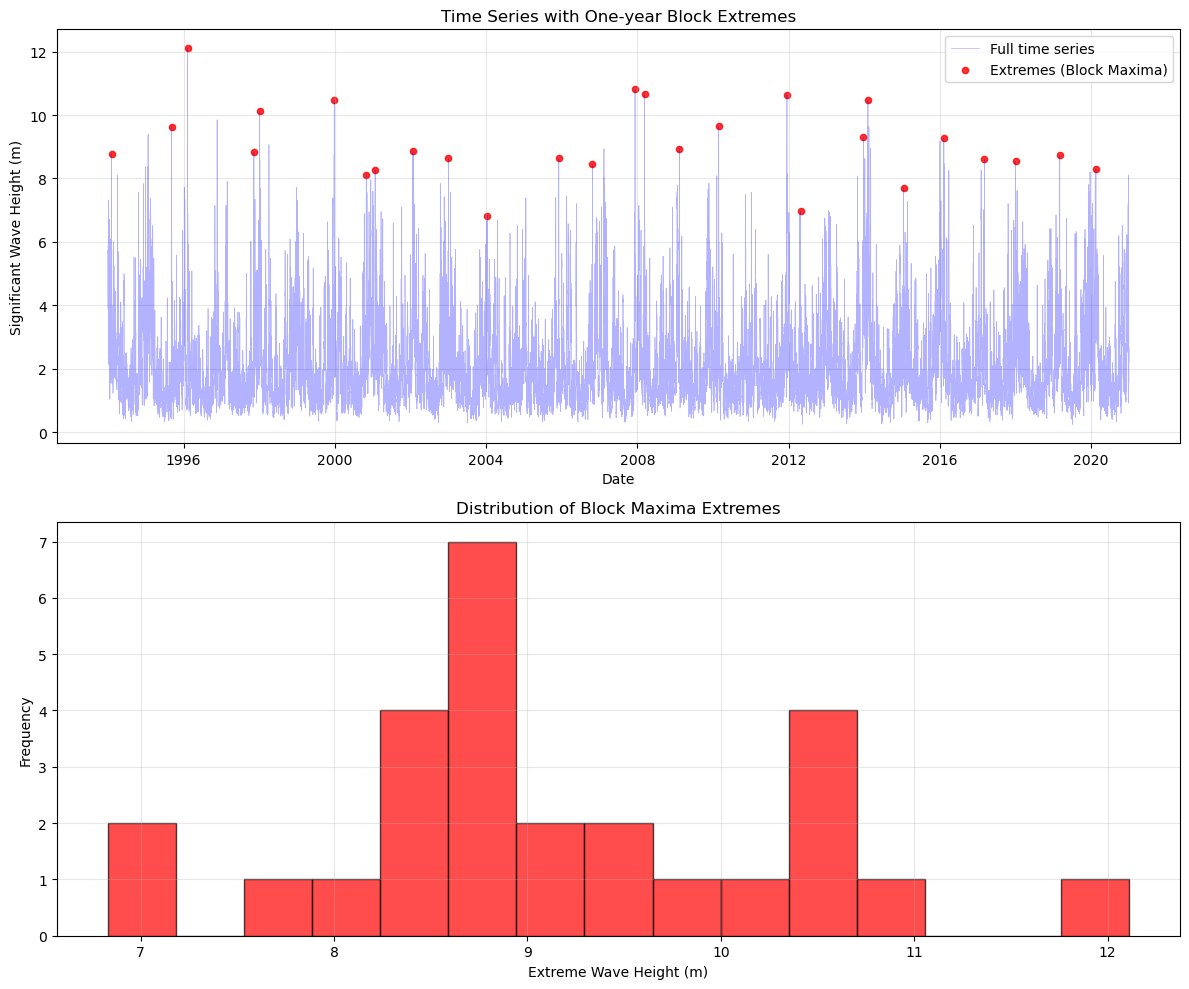

Number of extremes: 27
Mean extreme value: 9.126 m
Maximum extreme value: 12.110 m
Minimum extreme value: 6.832 m
Standard deviation: 1.208 m


In [229]:
# extremes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Time series with extremes highlighted
ax1.plot(data.index, data.hs, 'b-', alpha=0.3, linewidth=0.5, label='Full time series')
ax1.scatter(model_bm.extremes.index, model_bm.extremes.values, color='red', s=20, alpha=0.8, label='Extremes (Block Maxima)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Significant Wave Height (m)')
ax1.set_title('Time Series with One-year Block Extremes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Histogram of extremes
ax2.hist(model_bm.extremes.values, bins=15, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Extreme Wave Height (m)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Block Maxima Extremes')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the extremes
print(f"Number of extremes: {len(model_bm.extremes)}")
print(f"Mean extreme value: {model_bm.extremes.mean():.3f} m")
print(f"Maximum extreme value: {model_bm.extremes.max():.3f} m")
print(f"Minimum extreme value: {model_bm.extremes.min():.3f} m")
print(f"Standard deviation: {model_bm.extremes.std():.3f} m")

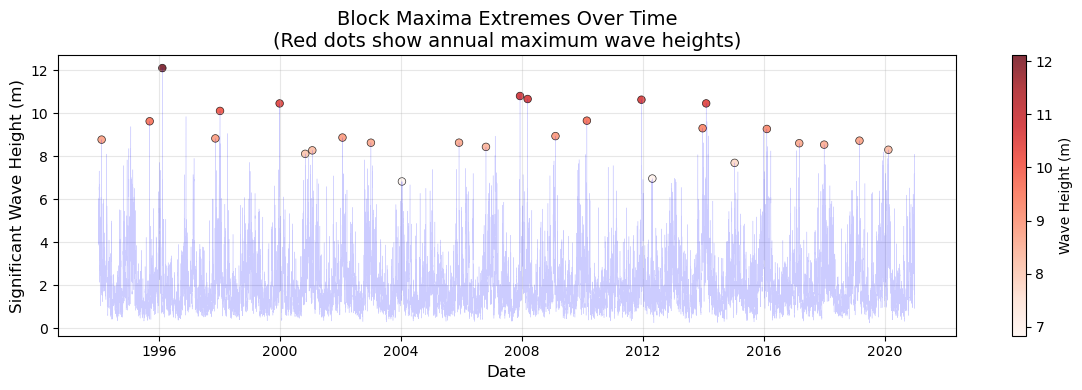

In [230]:
# More detailed manual plotting of extremes
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot the full time series
ax.plot(data.index, data.hs, 'b-', alpha=0.2, linewidth=0.3, label='Full time series')

# Highlight extremes with different colors based on magnitude
extremes = model_bm.extremes
colors = plt.cm.Reds(np.linspace(0.3, 1, len(extremes)))
scatter = ax.scatter(extremes.index, extremes.values, c=extremes.values, 
                    cmap='Reds', s=30, alpha=0.8, edgecolors='black', linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Wave Height (m)')

# Customize the plot
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Significant Wave Height (m)', fontsize=12)
ax.set_title('Block Maxima Extremes Over Time\n(Red dots show annual maximum wave heights)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# lets execute GEV fit on the extremes
model_bm.fit_model()

model_bm.plot_diagnostic(alpha=0.95)
plt.savefig('graphs/diagnostic_plot_bm.png', dpi=200, bbox_inches='tight')

In [232]:
# Calculate return values for 1-year and 50-year period
return_period = [1.01,1.1, 1.2, 1.3, 1.4,1.5, 2, 5, 10, 25, 50]
summary_bm = model_bm.get_summary(return_period=return_period, alpha=0.95)
print(summary_bm)


               return value  lower ci  upper ci
return period                                  
1.01                   6.90      6.36      7.65
1.10                   7.61      7.16      8.16
1.20                   7.92      7.51      8.41
1.30                   8.14      7.74      8.59
1.40                   8.31      7.90      8.75
1.50                   8.45      8.03      8.87
2.00                   8.95      8.51      9.38
5.00                  10.18      9.42     10.70
10.00                 10.99     10.06     11.61
25.00                 12.01     10.70     12.74
50.00                 12.78     11.18     13.61


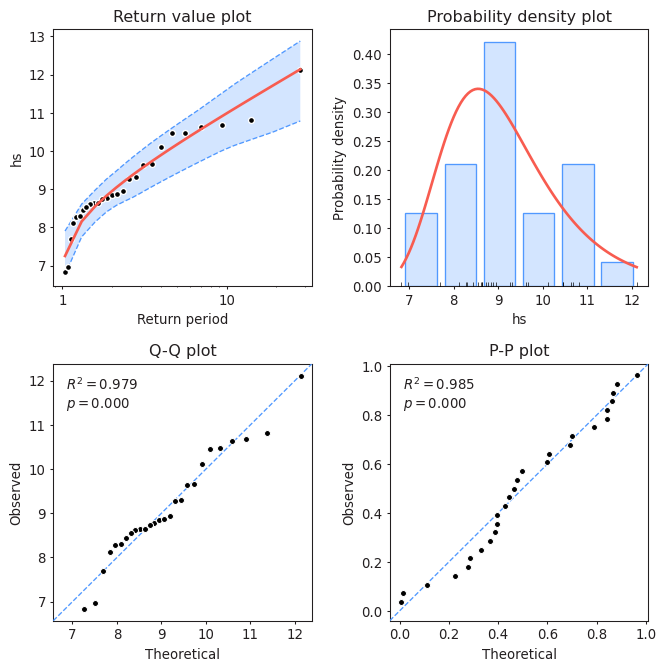

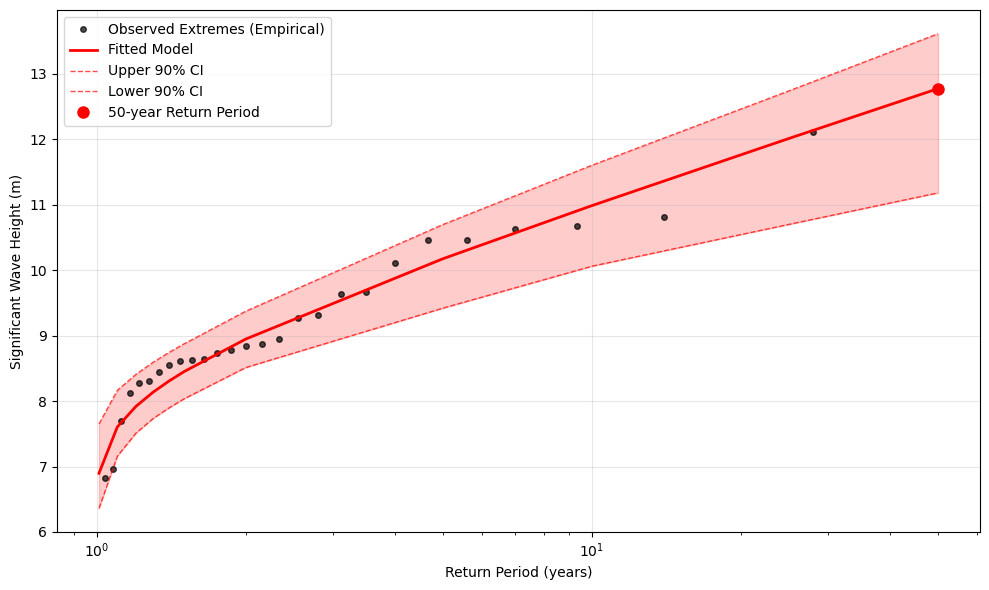

In [233]:
# Plot with correct empirical return periods
fig, ax = plt.subplots(figsize=(10, 6))

# Get correct empirical return periods
sorted_extremes = np.sort(model_bm.extremes.values)[::-1]  # Sort descending
n_extremes = len(sorted_extremes)

# Correct empirical return period calculation
# For block maxima, empirical return period = (n + 1) / (rank)
empirical_return_periods = (n_extremes + 1) / np.arange(1, n_extremes + 1)

# Plot your observed data with correct empirical return periods
ax.semilogx(empirical_return_periods, sorted_extremes, 'ko', markersize=4, alpha=0.7, label='Observed Extremes (Empirical)')

# Add fitted model for comparison

ax.semilogx(summary_bm.index, summary_bm['return value'], 'r-', linewidth=2, label='Fitted Model')

# Add confidence intervals
ax.semilogx(summary_bm.index, summary_bm['upper ci'], 'r--', linewidth=1, alpha=0.7, label='Upper 90% CI')
ax.semilogx(summary_bm.index, summary_bm['lower ci'], 'r--', linewidth=1, alpha=0.7, label='Lower 90% CI')

# Fill between confidence intervals
ax.fill_between(summary_bm.index, summary_bm['lower ci'], summary_bm['upper ci'], alpha=0.2, color='red')

# Highlight 50-year point
ax.semilogx(50, summary_bm.loc[50, 'return value'], 'ro', markersize=8, label='50-year Return Period')

ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Significant Wave Height (m)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig('graphs/gev_fit_bm.png')
plt.show()

---

### I.B.2. Peak-Over-Threshold (POT) Analysis

Next, we will apply the Peak-Over-Threshold (POT) method. This involves selecting an appropriate high threshold for $H_s$. For this analysis, we will use the **98th quantile of the $H_s$ data** as the threshold. To ensure the peaks are independent events, we will use a **48-hour ('2D') declustering window**. The excesses (the peaks that exceed this threshold) are then fitted to a **Generalized Pareto Distribution (GPD)**.

In [234]:
# define the threshold for the POT method
# an empricial threshold is used here based on the data's return period
threshold = data.hs.quantile(0.99)  # meters
print(f'Threshold: {threshold} m')

# Fit Peaks-over-Threshold model for Hs
model_pot = EVA(data.hs)

model_pot.get_extremes(
    method="POT",
    threshold=threshold,
    r="48H",
    extremes_type="high",
)

model_pot.fit_model()

Threshold: 6.46426000000001 m


In [235]:
return_period = [1.01,1.1, 1.2, 1.3, 1.4,1.5, 2, 5, 10, 25, 50]
summary_pot = model_pot.get_summary(
    return_period=return_period,
    return_period_size="365.2425D",
    alpha=0.95
)
print(summary_pot)


               return value  lower ci  upper ci
return period                                  
1.01                   8.57      8.29      8.85
1.10                   8.67      8.37      8.94
1.20                   8.76      8.45      9.03
1.30                   8.85      8.52      9.12
1.40                   8.93      8.59      9.19
1.50                   9.00      8.65      9.28
2.00                   9.29      8.90      9.60
5.00                  10.13      9.61     10.57
10.00                 10.68     10.03     11.24
25.00                 11.32     10.42     12.12
50.00                 11.73     10.66     12.69


In [236]:
print(summary_bm)


               return value  lower ci  upper ci
return period                                  
1.01                   6.90      6.36      7.65
1.10                   7.61      7.16      8.16
1.20                   7.92      7.51      8.41
1.30                   8.14      7.74      8.59
1.40                   8.31      7.90      8.75
1.50                   8.45      8.03      8.87
2.00                   8.95      8.51      9.38
5.00                  10.18      9.42     10.70
10.00                 10.99     10.06     11.61
25.00                 12.01     10.70     12.74
50.00                 12.78     11.18     13.61


In [237]:
print(summary_pot)


               return value  lower ci  upper ci
return period                                  
1.01                   8.57      8.29      8.85
1.10                   8.67      8.37      8.94
1.20                   8.76      8.45      9.03
1.30                   8.85      8.52      9.12
1.40                   8.93      8.59      9.19
1.50                   9.00      8.65      9.28
2.00                   9.29      8.90      9.60
5.00                  10.13      9.61     10.57
10.00                 10.68     10.03     11.24
25.00                 11.32     10.42     12.12
50.00                 11.73     10.66     12.69


In [238]:
model_bm.plot_extremes()

(<Figure size 768x480 with 1 Axes>, <Axes: xlabel='date-time', ylabel='hs'>)

The parameter alpha specifies the confidence limits (default = 0.95).

In [239]:
model_pot.plot_diagnostic(alpha=0.95)
plt.savefig('graphs/diagnostic_plot_pot.png', dpi=200, bbox_inches='tight')



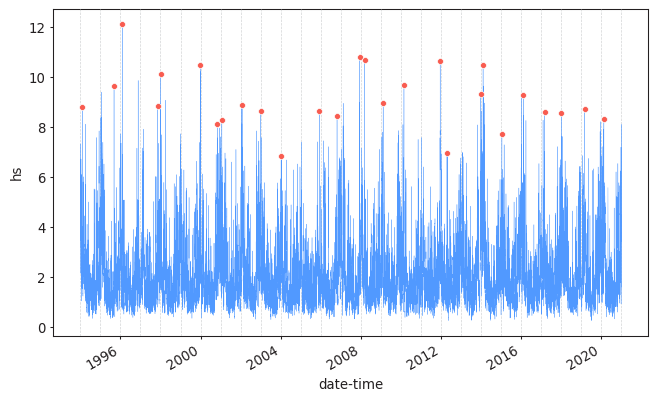

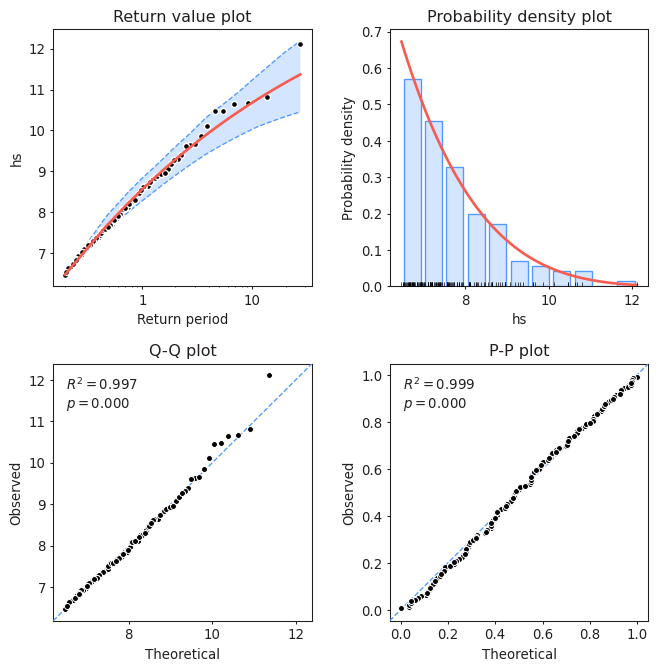

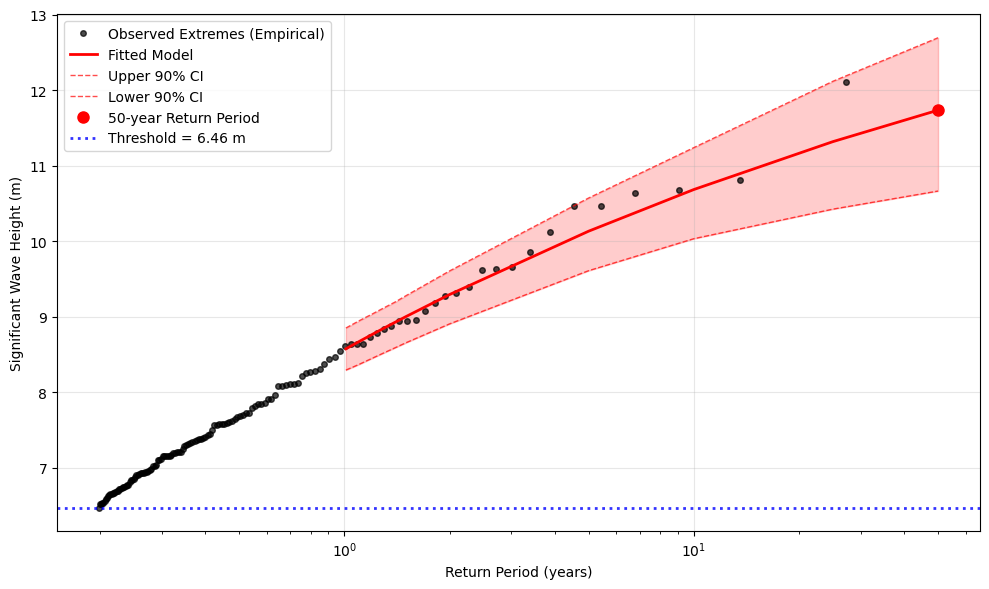

In [240]:
# Plot with extended model to 1 year
fig, ax = plt.subplots(figsize=(10, 6))

# Get correct empirical return periods
sorted_extremes = np.sort(model_pot.extremes.values)[::-1]  # Sort descending
n_extremes = len(sorted_extremes)

# Correct empirical return period calculation
# duration in years
years = (model_pot.data.index.max() - model_pot.data.index.min()).days / 365.25
rate = n_extremes / years  # exceedances per year

empirical_return_periods = (n_extremes + 1) / np.arange(1, n_extremes + 1) / rate

# Plot your observed data with correct empirical return periods
ax.semilogx(empirical_return_periods, sorted_extremes, 'ko', markersize=4, alpha=0.7, label='Observed Extremes (Empirical)')

# Add fitted model with extended range to 1 year

ax.semilogx(summary_pot.index, summary_pot['return value'], 'r-', linewidth=2, label='Fitted Model')

# Add confidence intervals
ax.semilogx(summary_pot.index, summary_pot['upper ci'], 'r--', linewidth=1, alpha=0.7, label='Upper 90% CI')
ax.semilogx(summary_pot.index, summary_pot['lower ci'], 'r--', linewidth=1, alpha=0.7, label='Lower 90% CI')

# Fill between confidence intervals
ax.fill_between(summary_pot.index, summary_pot['lower ci'], summary_pot['upper ci'], alpha=0.2, color='red')

# Highlight 50-year point
ax.semilogx(50, summary_pot.loc[50, 'return value'], 'ro', markersize=8, label='50-year Return Period')

# Add threshold as dotted horizontal line
ax.axhline(y=threshold, color='blue', linestyle=':', linewidth=2, alpha=0.8, label=f'Threshold = {threshold:.2f} m')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Significant Wave Height (m)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()
plt.savefig('graphs/gpd_fit_pot.png')
plt.close()

In [241]:
extremes_indices_pot = model_pot.extremes.index
extremes_df_pot = (
    pd.DataFrame({'timestamp': extremes_indices_pot, 'hs': model_pot.extremes.values})
    .merge(
        data[['dir','wspd','Tm02']].reset_index().rename(columns={'index':'timestamp'}),
        on='timestamp',
        how='left'
    )

)
extremes_df_bm.to_csv('data/extremes_pot.csv', index=False)

The parameter n_samples indicates the number of bootstrap samples used to estimate the confidence bounds.

In [242]:
# add direction and period to the extremes
indices_bm = model_bm.extremes.index
indices_pot = model_pot.extremes.index

periods_bm = data.loc[indices_bm, ['tp']]
periods_pot = data.loc[indices_pot, ['tp']]

dir_bm = data.loc[indices_bm, ['dir']]
dir_pot = data.loc[indices_pot, ['dir']]

# Extract quantiles for the periods

q10_periods_pot = periods_pot.quantile(0.10)
q50_periods_pot = periods_pot.quantile(0.50)
q90_periods_pot = periods_pot.quantile(0.90)

q10_periods_bm = periods_bm.quantile(0.10)
q50_periods_bm = periods_bm.quantile(0.50)
q90_periods_bm = periods_bm.quantile(0.90)

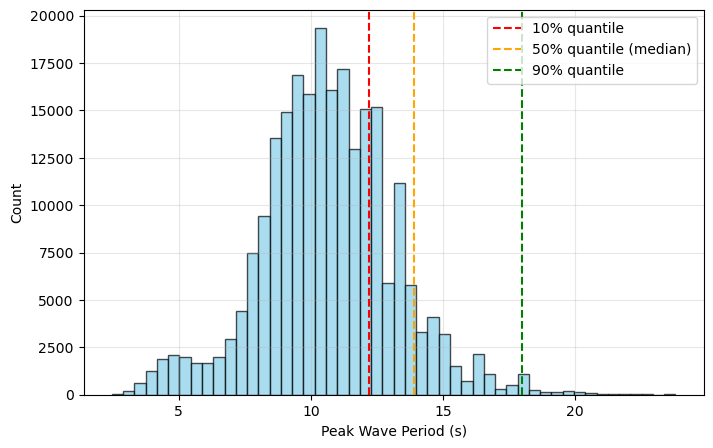

In [243]:
plt.figure(figsize=(8,5))
plt.hist(data.tp, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(q10_periods_pot.values, color='red', linestyle='--', label='10% quantile')
plt.axvline(q50_periods_pot.values, color='orange', linestyle='--', label='50% quantile (median)')
plt.axvline(q90_periods_pot.values, color='green', linestyle='--', label='90% quantile')
plt.xlabel('Peak Wave Period (s)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('graphs/extreme_period_quantiles_pot.png', dpi=200, bbox_inches='tight')
plt.show()

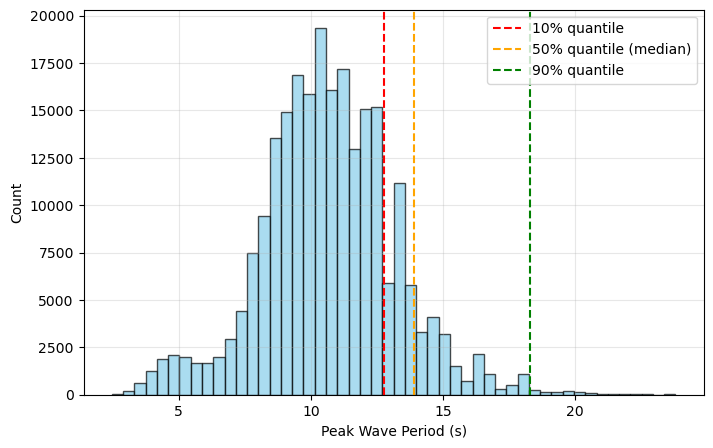

In [244]:
plt.figure(figsize=(8,5))
plt.hist(data.tp, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
plt.axvline(q10_periods_bm.values, color='red', linestyle='--', label='10% quantile')
plt.axvline(q50_periods_bm.values, color='orange', linestyle='--', label='50% quantile (median)')
plt.axvline(q90_periods_bm.values, color='green', linestyle='--', label='90% quantile')
plt.xlabel('Peak Wave Period (s)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('graphs/extreme_period_quantiles_bm.png', dpi=200, bbox_inches='tight')
plt.show()

In [245]:
# Merge the two summary dataframes
summary_bm['Method'] = 'Block Maxima'
summary_pot['Method'] = 'POT'
comparison_df = pd.concat([summary_bm, summary_pot])

# Format the table for display
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
comparison_df.to_csv('data/summary_bm_pot.csv', index=False)

In [246]:
comparison_df.head()

,return value,lower ci,upper ci,Method
return period,,,,
1.01,6.90,6.36,7.65,Block Maxima
1.10,7.61,7.16,8.16,Block Maxima
1.20,7.92,7.51,8.41,Block Maxima
1.30,8.14,7.74,8.59,Block Maxima
1.40,8.31,7.90,8.75,Block Maxima


In [247]:
delta_return_value = summary_bm["return value"] - summary_pot["return value"]
delta_lower_ci = summary_bm["lower ci"] - summary_pot["lower ci"]
delta_upper_ci = summary_bm["upper ci"] - summary_pot["upper ci"]

In [248]:
print(delta_return_value.values)
print(delta_lower_ci.values)
print(delta_upper_ci.values)

[-1.67567811 -1.0615414  -0.84107854 -0.71020729 -0.61845041 -0.54862411
 -0.34238809  0.04528506  0.30593659  0.69801489  1.04247615]
[-1.93077434 -1.20799738 -0.93502624 -0.7858861  -0.69122314 -0.61838206
 -0.38923411 -0.18688789  0.03060698  0.27847079  0.52013134]
[-1.19739463 -0.77803502 -0.62247389 -0.52286057 -0.44893747 -0.40102302
 -0.2288174   0.12885408  0.36776579  0.62641004  0.92260526]


In [249]:
print(model_pot.extremes.index)

DatetimeIndex(['1994-01-05 05:00:00', '1994-01-12 23:00:00',
               '1994-02-03 19:00:00', '1994-04-01 02:00:00',
               '1994-10-23 05:00:00', '1994-12-08 18:00:00',
               '1994-12-29 22:00:00', '1995-01-22 17:00:00',
               '1995-01-28 22:00:00', '1995-02-10 19:00:00',
               ...
               '2019-12-13 23:00:00', '2019-12-22 01:00:00',
               '2020-01-09 22:00:00', '2020-01-14 15:00:00',
               '2020-02-10 03:00:00', '2020-02-13 16:00:00',
               '2020-02-16 13:00:00', '2020-10-28 13:00:00',
               '2020-12-23 20:00:00', '2020-12-28 13:00:00'],
              dtype='datetime64[ns]', name='date-time', length=137, freq=None)


In [250]:
# Analysis of associated wave period and direction for extreme events

# Get extreme events from both BM and POT methods
bm_extremes = model_bm.extremes  # Block Maxima extremes
pot_extremes = model_pot.extremes  # POT extremes

print("=== EXTREME WAVE EVENTS ANALYSIS ===")
print(f"BM method: {len(bm_extremes)} extremes")
print(f"POT method: {len(pot_extremes)} extremes")

# Get associated wave periods and directions for BM extremes
bm_periods = data.loc[bm_extremes.index, 'Tm02']
bm_directions = data.loc[bm_extremes.index, 'dir']

# Get associated wave periods and directions for POT extremes  
pot_periods = data.loc[pot_extremes.index, 'Tm02']
pot_directions = data.loc[pot_extremes.index, 'dir']

# Calculate quantiles for wave periods
bm_period_quantiles = bm_periods.quantile([0.10, 0.50, 0.90])
pot_period_quantiles = pot_periods.quantile([0.10, 0.50, 0.90])

print("\n=== WAVE PERIOD QUANTILES (s) ===")
print("BM Method:")
print(f"  10% quantile: {bm_period_quantiles[0.10]:.2f} s")
print(f"  50% quantile: {bm_period_quantiles[0.50]:.2f} s") 
print(f"  90% quantile: {bm_period_quantiles[0.90]:.2f} s")

print("\nPOT Method:")
print(f"  10% quantile: {pot_period_quantiles[0.10]:.2f} s")
print(f"  50% quantile: {pot_period_quantiles[0.50]:.2f} s")
print(f"  90% quantile: {pot_period_quantiles[0.90]:.2f} s")

# Calculate circular statistics for wave directions
def circular_mean_deg(directions):
    """Calculate circular mean of directions in degrees"""
    directions_rad = np.deg2rad(directions.dropna())
    if len(directions_rad) == 0:
        return np.nan
    mean_x = np.cos(directions_rad).mean()
    mean_y = np.sin(directions_rad).mean()
    return np.degrees(np.arctan2(mean_y, mean_x)) % 360

def circular_std_deg(directions):
    """Calculate circular standard deviation of directions in degrees"""
    directions_rad = np.deg2rad(directions.dropna())
    if len(directions_rad) == 0:
        return np.nan
    R = np.sqrt(np.cos(directions_rad).mean()**2 + np.sin(directions_rad).mean()**2)
    return np.degrees(np.sqrt(-2 * np.log(R)))

# Calculate direction statistics for extremes
bm_dir_mean = circular_mean_deg(bm_directions)
bm_dir_std = circular_std_deg(bm_directions)
pot_dir_mean = circular_mean_deg(pot_directions)
pot_dir_std = circular_std_deg(pot_directions)

# Calculate direction statistics for entire dataset
all_dir_mean = circular_mean_deg(data['dir'])
all_dir_std = circular_std_deg(data['dir'])

print("\n=== WAVE DIRECTION ANALYSIS ===")
print("BM Method Extremes:")
print(f"  Mean direction: {bm_dir_mean:.1f}°")
print(f"  Circular std: {bm_dir_std:.1f}°")

print("\nPOT Method Extremes:")
print(f"  Mean direction: {pot_dir_mean:.1f}°")
print(f"  Circular std: {pot_dir_std:.1f}°")

print("\nEntire Dataset:")
print(f"  Mean direction: {all_dir_mean:.1f}°")
print(f"  Circular std: {all_dir_std:.1f}°")

# Create summary table
summary_data = {
    'Method': ['BM Extremes', 'POT Extremes', 'All Data'],
    'Count': [len(bm_extremes), len(pot_extremes), len(data)],
    'Mean_Direction_deg': [bm_dir_mean, pot_dir_mean, all_dir_mean],
    'Circular_Std_deg': [bm_dir_std, pot_dir_std, all_dir_std],
    'Period_10pct_s': [bm_period_quantiles[0.10], pot_period_quantiles[0.10], np.nan],
    'Period_50pct_s': [bm_period_quantiles[0.50], pot_period_quantiles[0.50], np.nan],
    'Period_90pct_s': [bm_period_quantiles[0.90], pot_period_quantiles[0.90], np.nan]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== SUMMARY TABLE ===")
print(summary_df.round(2))

# Save to CSV
summary_df.to_csv('data/summary_bm_pot.csv', index=False)
print(f"\nSummary saved to: data/summary_bm_pot.csv")

=== EXTREME WAVE EVENTS ANALYSIS ===
BM method: 27 extremes
POT method: 137 extremes

=== WAVE PERIOD QUANTILES (s) ===
BM Method:
  10% quantile: 8.94 s
  50% quantile: 9.47 s
  90% quantile: 10.68 s

POT Method:
  10% quantile: 8.40 s
  50% quantile: 9.06 s
  90% quantile: 10.01 s

=== WAVE DIRECTION ANALYSIS ===
BM Method Extremes:
  Mean direction: 255.9°
  Circular std: 11.6°

POT Method Extremes:
  Mean direction: 260.4°
  Circular std: 12.6°

Entire Dataset:
  Mean direction: 275.5°
  Circular std: 34.5°

=== SUMMARY TABLE ===
         Method   Count  Mean_Direction_deg  Circular_Std_deg  Period_10pct_s  \
0   BM Extremes      27              255.94             11.64            8.94   
1  POT Extremes     137              260.42             12.58            8.40   
2      All Data  236688              275.49             34.48             NaN   

   Period_50pct_s  Period_90pct_s  
0            9.47           10.68  
1            9.06           10.01  
2             NaN          

### BM vs. POT: Comparison of Extreme Event Characteristics

**Method**

- Characteristics of extreme wave events were compared using two methods: **Block Maxima (BM)** and **Peak-Over-Threshold (POT)**.
- The **BM method** (using annual maxima) identified **27 extreme events**.
- The **POT method** (using the 98th quantile and 48-hour declustering) identified **137 extreme events**.
- We analyzed:
  1.  The physical characteristics (wave period, direction, and seasonality) of the event sets.
  2.  A quantitative model comparison by calculating the delta ($\Delta = \text{BM value} - \text{POT value}$) for the $H_s$ return value and its 95% confidence intervals.

---

**Results: Wave Period (s)**

- **BM Extremes:**
  - 10% quantile: **8.94 s**
  - 50% quantile (Median): **9.47 s**
  - 90% quantile: **10.68 s**
- **POT Extremes:**
  - 10% quantile: **8.40 s**
  - 50% quantile (Median): **9.06 s**
  - 90% quantile: **10.01 s**

---

**Results: Event Characteristics (Direction & Seasonality)**

**Wave Direction (°)**
- **BM Extremes:**
  - Mean direction: **255.9°**
  - Circular std: **11.6°**
- **POT ExtremES:**
  - Mean direction: **260.4°**
  - Circular std: **12.6°**
- **Entire Dataset:**
  - Mean direction: **275.5°**
  - Circular std: **34.5°**

**Seasonality (based on 27 BM events)**
- **Winter (Dec, Jan, Feb): 21 events (77.8%)**
- Spring (Mar, Apr, May): 2 events (7.4%)
- Summer (Jun, Jul, Aug): 0 events (0.0%)
- Autumn (Sep, Oct, Nov): 4 events (14.8%)

---

**Results: Model Deltas (m)**

| Return Period (yr) | Return Value Delta (BM-POT) | Lower CI Delta (BM-POT) | Upper CI Delta (BM-POT) |
| :--- | :---: | :---: | :---: |
| 1.01 | -1.64 | -1.81 | -0.99 |
| 1.1 | -1.03 | -1.10 | -0.67 |
| 1.2 | -0.81 | -0.86 | -0.54 |
| 1.3 | -0.68 | -0.74 | -0.47 |
| 1.4 | -0.59 | -0.66 | -0.43 |
| 1.5 | -0.53 | -0.60 | -0.41 |
| 2.0 | -0.33 | -0.39 | -0.32 |
| 5.0 | 0.05 | 0.02 | -0.13 |
| 10.0 | 0.31 | 0.24 | 0.01 |
| 25.0 | 0.71 | 0.53 | 0.52 |
| 50.0 | 1.07 | 0.77 | 0.88 |

---

**Interpretation**

- **Physical Characteristics:**
  - **Seasonality & Direction:** The physical drivers for extreme events are highly consistent. The analysis of annual maxima shows that events are **overwhelmingly concentrated in Winter (77.8%)** and nonexistent in Summer.
  - Furthermore, these events originate from a **highly consistent direction** (255.9°-260.4°) that is distinct from the overall mean wave direction (275.5°), suggesting a specific and predictable storm track.
  - **Period:** Events identified by the BM method (the largest of the large) are associated with **longer wave periods** than the broader set of POT events (e.g., BM median of 9.47 s vs POT median of 9.06 s).

- **Model Divergence:**
  - The two models show a **clear structural divergence** depending on the return period.
  - **Short-Term Events (< 5 years):** The **POT model is more conservative** (predicts higher $H_s$ values), as shown by the negative deltas. For a 2-year event, the BM estimate is 0.33 m lower.
  - **Long-Term Events (> 10 years):** The **BM model becomes more conservative** (predicts higher $H_s$ values), with the 50-year estimate being 1.07 m higher than POT's.
  - **Crossover Point:** The models are in closest agreement around the **5-year return period**.

- **Conclusion:** This divergence is critical for engineering design. The POT model, based on **137 data points**, is statistically more stable. The BM model, using only 27 annual maxima, is highly sensitive to the few largest events in the record, which appears to be driving its steeper, higher-extrapolated values at the 25- and 50-year periods.

5. (optional) Comparison to multivariate method. If you have time to go further, you may
search for the MHKiT python toolbox that will allow you to calculate the 50-year return contour
using the modified I-FORM method.
Q: Show a graphic of your results and compare this to the values obtained with the univariate
analysis (e.g. add those points to the environmental contour plot). Are they similar?

In [251]:
from mhkit.wave import resource, contours, graphics

In [252]:
# Return period (years) of interest
period = 50



# Get only the values from the DataFrame
hs = data['hs'].values
tp = data['tp'].values

# Delta time of sea-states
dt = (data.index[2] - data.index[1]).seconds

# Get the contour values
copula = contours.environmental_contours(hs, tp, dt, period, "PCA", return_PCA=True)
Hm0_contour = copula["PCA_x1"]
Te_contour = copula["PCA_x2"]

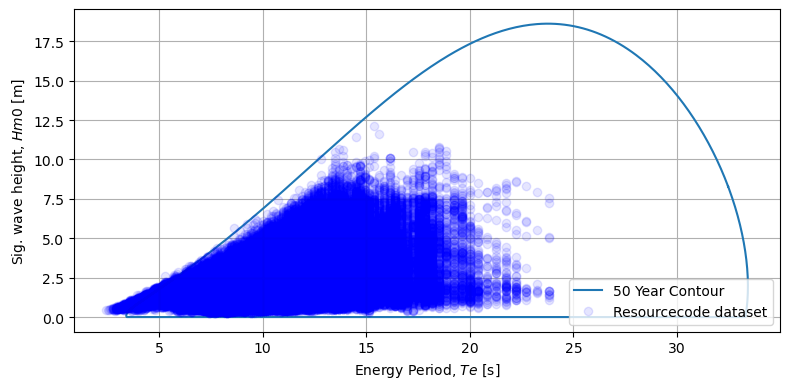

In [253]:
fig, ax = plt.subplots(figsize=(8, 4))
# %matplotlib inline
ax = graphics.plot_environmental_contour(
    tp,
    hs,
    Te_contour,
    Hm0_contour,
    data_label="Resourcecode dataset",
    contour_label="50 Year Contour",
    x_label="Energy Period, $Te$ [s]",
    y_label="Sig. wave height, $Hm0$ [m]",
    ax=ax,
)
plt.show()